In [1]:
import os
import gzip
import pickle
import random
import datetime
import platform
import warnings

import numpy as np
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm
from collections import OrderedDict
from urllib.request import urlretrieve

In [2]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
# 현재 OS 및 파이썬 버전 확인
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 라이브러리 버전 확인
from importlib.metadata import version
print("numpy version : {}".format(version("numpy")))
print("matplotlib version : {}".format(version("matplotlib")))

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# matplotlib의 해상도 높이기
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Current OS: Linux
Python Version: 3.8.19
numpy version : 1.23.5
matplotlib version : 3.7.1


In [4]:
# MNIST를 다운받을 경로
url = 'https://raw.githubusercontent.com/fgnt/mnist/master/'

# MNIST를 저장할 디렉토리 (colab 사용 시, 기본 디렉토리는 `/content`)
# 만일 구글 드라이브를 마운트해서 사용할 경우, 사용하고자 하는 드라이브 위치를 `os.getcwd()` 부분에 덮어씌워 작성
dataset_dir = os.path.join('/home/pervinco/Datasets', 'MNIST')

# Pickle로 저장할 경로
save_file = dataset_dir + "/mnist.pkl"

# MNIST 데이터셋의 파일명 (딕셔너리)
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# 해당 경로가 없을 시 디렉토리 새로 생성
os.makedirs(dataset_dir, exist_ok=True)

# 해당 경로에 존재하지 않는 파일을 모두 다운로드
for filename in key_file.values():
    if filename not in os.listdir(dataset_dir):
        urlretrieve(url + filename, os.path.join(dataset_dir, filename))
        print("Downloaded %s to %s" % (filename, dataset_dir))

In [5]:
def _load_label(file_name):
    """MNIST 데이터셋 라벨을 NumPy Array로 변환하여 불러오기
    """
    file_path = dataset_dir + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

def _load_img(file_name):
    """MNIST 데이터셋 이미지을 NumPy Array로 변환하여 불러오기
    """
    file_path = dataset_dir + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28*28)
    return data

def _convert_numpy():
    """NumPy Array로 불러온 MNIST 데이터셋을 딕셔너리로 매핑
    """
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    return dataset

def init_mnist():
    """MNIST 데이터셋을 Pickle화
    """
    dataset = _convert_numpy()
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    """
    # Pickle화 됐는지 확인
    if not os.path.exists(save_file):
        init_mnist()

    # Pickle화된 MNIST 데이터셋 가져오기
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    # 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    # 레이블을 원-핫(one-hot) 배열로 변환
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    # 입력 이미지를 1차원 배열로 만듬
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [6]:
# MNIST 데이터셋 불러오기
(X_train, y_train), (X_test, y_test) = load_mnist()

In [7]:
# 학습 데이터의 인덱스를 랜덤하게 셔플
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# 섞인 인덱스를 기반으로 train과 valid 데이터 분할
# 과적합이 되는 상황을 유도하기 위해서 데이터의 수를 줄임
valid_idx = indices[:10000]
train_idx = indices[10000:]

# 학습 데이터 중 일부를 검증 데이터로 활용
X_valid, y_valid = X_train[valid_idx], y_train[valid_idx]
X_train, y_train = X_train[train_idx], y_train[train_idx]

# MNIST 데이터셋 살펴보기
print(f"학습 데이터: {len(X_train):,}개\n검증 데이터: {len(X_valid):,}개\n평가 데이터: {len(X_test):,}개")

학습 데이터: 50,000개
검증 데이터: 10,000개
평가 데이터: 10,000개


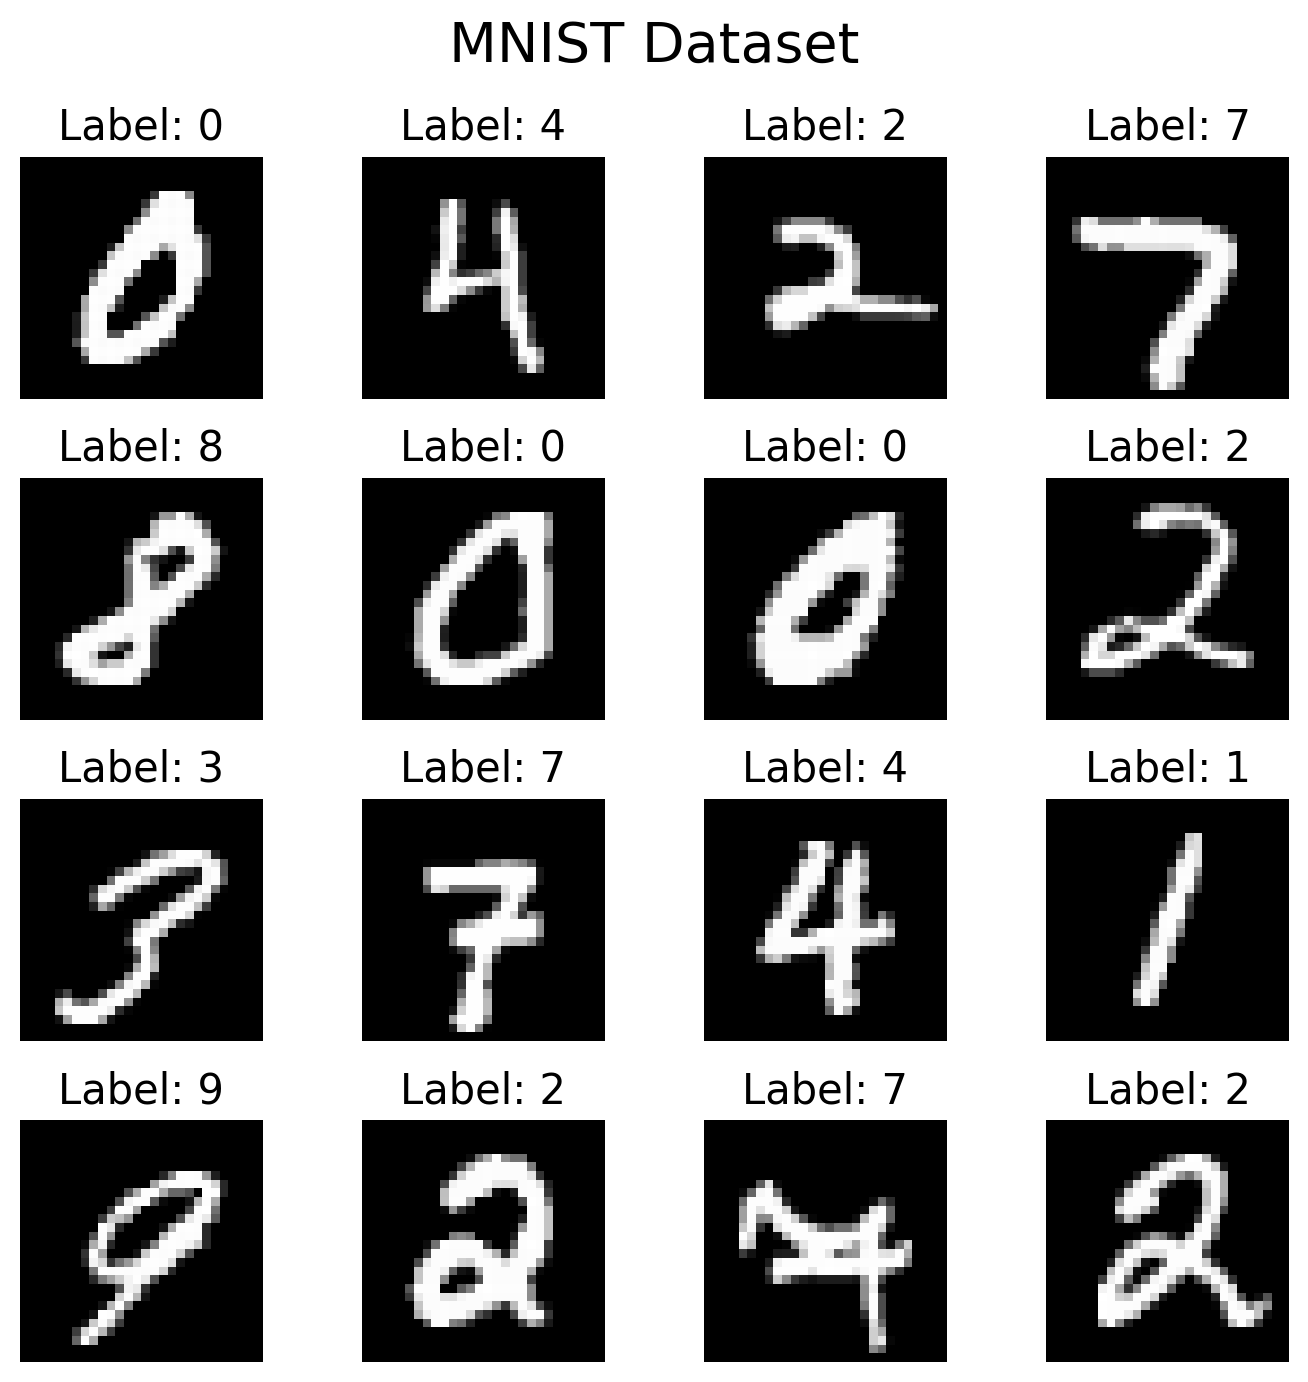

In [8]:
# MNIST 데이터셋 중 임의로 16개의 샘플 살펴봅시다
plt.figure(figsize=(7,7))
for n, i in enumerate(np.random.randint(0, len(X_train), size=16), start=1):
    plt.subplot(4,4,n)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[i]}", fontsize=15)
    plt.axis('off')
plt.suptitle('MNIST Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [9]:
def sigmoid(x):
    '''시그모이드 함수'''
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    '''시그모이드 함수의 그래디언트'''
    return (1.0 - sigmoid(x)) * sigmoid(x)


class Sigmoid:
    '''시그모이드 레이어'''
    def __init__(self):
        self.out = None

    def forward(self, x):
        '''시그모이드 레이어의 순전파(forward propagation)'''
        self.out = sigmoid(x)  # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴
        return self.out

    def backward(self, dout):
        '''시그모이드 레이어의 역전파(backpropagation)'''
        dx = dout * (1.0 - self.out) * self.out
        return dx  # 역전파가 흐를시 그 그래디언트 값을 리턴

In [10]:
def relu(x):
    '''ReLU 함수'''
    return np.maximum(0, x)

def relu_grad(x):
    '''ReLU 함수의 그래디언트'''
    grad = np.zeros(x)
    grad[x >= 0] = 1
    return grad

class Relu:
    '''ReLU 레이어'''
    def __init__(self):
        self.mask = None

    def forward(self, x):
        '''ReLU 레이어의 순전파(forward propagation)'''
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out  # 순전파가 흐를 시 그 결과물을 attribute로 저장 및 리턴

    def backward(self, dout):
        '''ReLU 레이어의 역전파(backpropagation)'''
        dout[self.mask] = 0
        dx = dout
        return dx  # 역전파가 흐를시 그 그래디언트 값을 리턴

In [11]:
class FCLayer:
    '''완전 연결 레이어'''
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        '''완전 연결 레이어의 순전파(forward propagation)'''
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        '''완전 연결 레이어의 역전파(backpropagation)'''
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)

        return dx

In [12]:
def softmax(x):
    '''소프트맥스 함수'''
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)

    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y_true, y_pred):
    if y_true.ndim == 1:
        y_pred = y_pred.reshape(1, y_pred.size)
        y_true = y_true.reshape(1, y_true.size)

    if y_pred.size == y_true.size:
        y_pred = y_pred.argmax(axis=1)

    batch_size = y_true.shape[0]

    return -np.sum(np.log(y_true[np.arange(batch_size), y_pred] + 1e-7)) / batch_size


class Softmax:
    '''소프트맥스 레이어'''
    def __init__(self):
        self.loss = None
        self.y_true = None
        self.y_pred = None

    def forward(self, x, y_pred):
        '''소프트맥스 레이어의 순전파(forward propagation)'''
        self.y_true = softmax(x)
        self.y_pred = y_pred
        self.loss = cross_entropy_error(self.y_true, self.y_pred)

        return self.loss

    def backward(self, dout=1):
        '''소프트맥스 레이어의 역전파(backpropagation)'''
        batch_size = self.y_pred.shape[0]
        if self.y_pred.size == self.y_true.size:
            dx = (self.y_true - self.y_pred) / batch_size
        else:
            dx = self.y_true.copy()
            dx[np.arange(batch_size), self.y_pred] -= 1
            dx = dx / batch_size

        return dx

In [13]:
# 신경망 학습 중 과적합을 방지하기 위한 Dropout 기법을 구현합니다.
class Dropout:

    # 초기화 함수
    def __init__(self, dropout_ratio=0.5):

        # dropout_ratio: 드롭아웃할 뉴런의 비율
        # e.g., 0.5는 50%의 뉴런을 무작위로 꺼버림
        self.dropout_ratio = dropout_ratio

        # mask: 드롭아웃할 뉴런을 결정하는 불리언 마스크.
        # 이는 오직 학습 시에만 사용됨.
        self.mask = None

    # 순전파 함수
    def forward(self, x, train_flag=True):

        # 학습 시 (train_flag가 True일 때)
        if train_flag:

            # 입력 데이터 x와 동일한 모양의 무작위 배열을 생성하고,
            # dropout_ratio보다 큰 값만 True로 설정
            # 이로써 어떤 뉴런을 꺼버릴지 (False)와 그대로 둘지 (True) 결정됨.
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio

            # mask를 사용해 x의 일부 뉴런을 꺼버림.
            return x * self.mask

        # 테스트 시 (train_flag가 False일 때)
        else:

            # Dropout의 비율만큼 스케일 조정하여 출력
            return x * (1.0 - self.dropout_ratio)

    # 역전파 함수
    def backward(self, dout):

        # mask를 사용하여, 순전파 때 꺼진 뉴런은 그래디언트도 전달되지 않게 함.
        return dout * self.mask

In [14]:
# BatchNormalization 클래스: 신경망의 학습을 안정화하고 가속화하는 Batch Normalization 기법을 구현합니다.
class BatchNormalization:

    # 초기화 함수
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):

        # gamma, beta: 학습 가능한 스케일 및 시프트 파라미터
        self.gamma = gamma
        self.beta = beta

        # momentum: 평균 및 분산의 움직이는 평균을 계산할 때 사용되는 모멘텀 값
        self.momentum = momentum

        # 입력 데이터의 형태를 저장 (예: (batch_size, features))
        self.input_shape = None

        # 학습 중 아닌 상황(예: 평가)에서 사용할 실행 중 평균 및 분산
        self.running_mean = running_mean
        self.running_var = running_var

        # 역전파 시 사용될 중간 값들
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    # 순전파 함수
    def forward(self, x, train_flag=True):
        self.input_shape = x.shape

        # 4D 텐서인 경우 2D로 변경
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        # running_mean 및 running_var 초기화
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)

        # 학습 시
        if train_flag:

            # 현재 배치의 평균 및 분산 계산
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std

            # 중간 값들 저장
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std

            # 실행 중 평균 및 분산 업데이트
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var

        # 평가 시
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))

        # 최종 출력 계산
        out = self.gamma * xn + self.beta

        return out.reshape(*self.input_shape)

    # 역전파 함수
    def backward(self, dout):

        # 4D 텐서인 경우 2D로 변경
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        # 역전파 계산을 위한 그래디언트들
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size

        # 학습 가능한 파라미터들의 그래디언트 저장
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx.reshape(*self.input_shape)


In [15]:
class Net:
    def __init__(self,
                 input_size,
                 hidden_size_list,
                 output_size,
                 use_dropout=False,
                 dropout_ratio=0,
                 use_batchnorm=False,
                 activation='relu',
                 weight_init_std='relu',
                 weight_decay_lambda=0
                 ):

        # 네트워크의 초기화
        self.input_size = input_size                    # 입력 크기 (예: 이미지의 픽셀 수)
        self.output_size = output_size                  # 출력 크기 (예: 분류할 클래스 수)
        self.hidden_size_list = hidden_size_list        # 은닉층의 뉴런 수 리스트
        self.hidden_layer_num = len(hidden_size_list)   # 은닉층의 개수
        self.weight_decay_lambda = weight_decay_lambda  # 가중치 감쇠
        self.use_dropout = use_dropout                  # 드롭아웃 사용 여부
        self.dropout_ratio = dropout_ratio              # 드롭아웃 사용시 계수
        self.use_batchnorm = use_batchnorm              # 배치 정규화 사용 여부

        # 신경망의 가중치
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 활성화 함수 지정 (ReLU, Sigmoid 등)
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}

        # 신경망의 레이어
        self.layers = OrderedDict()

        # 은닉층 생성
        for idx in range(1, self.hidden_layer_num+1):

            # 완전 연결 레이어 (Fully Connected Layer)
            self.layers[f'FC{idx}'] = FCLayer(
                self.params[f'W{idx}'],
                self.params[f'b{idx}']
            )

            # 배치 정규화 사용 여부에 따른 레이어 추가
            if self.use_batchnorm:
                self.params[f'gamma{idx}'] = np.ones(hidden_size_list[idx-1])
                self.params[f'beta{idx}'] = np.zeros(hidden_size_list[idx-1])
                self.layers[f'BN{idx}'] = BatchNormalization(
                    self.params[f'gamma{idx}'],
                    self.params[f'beta{idx}']
                )

            # 활성화 레이어 (Activation Layer: 예를 들면 ReLU나 Sigmoid)
            self.layers[f'Act{idx}'] = activation_layer[activation]()

            # 드롭아웃 사용 여부에 따른 레이어 추가
            if self.use_dropout:
                self.layers[f'Dropout{idx}'] = Dropout(self.dropout_ratio)

        # 출력층 (Last layer)
        idx = self.hidden_layer_num + 1
        self.layers[f'FC{idx}'] = FCLayer(
            self.params[f'W{idx}'],
            self.params[f'b{idx}']
        )

        # 소프트맥스 함수를 마지막 계층으로 설정 (분류 문제의 경우)
        self.last_layer = Softmax()

    def __init_weight(self, weight_init_std):
        """
        신경망의 가중치를 초기화합니다.
        Xavier 방식과 He 방식이 있습니다.
        """
        # 전체 네트워크의 각 층의 뉴런 수를 리스트로 구성
        all_size_list = [self.input_size] + \
            self.hidden_size_list + [self.output_size]

        # 모든 층을 순회하며 가중치를 초기화
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std

            # ReLU 활성화 함수를 사용할 경우 He 초기화 방법 사용
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])

            # Sigmoid 활성화 함수를 사용할 경우 Xavier 초기화 방법 사용
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            # 가중치와 편향 초기화
            self.params[f'W{idx}'] = scale * \
                np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params[f'b{idx}'] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flag=False):
        """
        입력 데이터(x)에 대한 예측 값을 반환합니다.
        """
        for key, layer in self.layers.items():
            # 드롭아웃 또는 배치 정규화 레이어일 경우 train_flag를 사용
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flag)
            else:
                x = layer.forward(x)
        return x

    def loss(self, y_pred, y_true):
        """
        정답(y_true)와 예측 값(y_pred)을 기반으로 손실 값을 계산합니다.
        L2 정규화(L2 Regularization)가 적용된 가중치 감쇠를 포함합니다.
        """
        weight_decay = 0

        # 가중치 감쇠 계산
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params[f'W{idx}']
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y_true, y_pred) + weight_decay

    def gradient(self):
        """
        신경망의 그래디언트(미분값)를 계산합니다.
        이는 네트워크의 파라미터 업데이트에 사용됩니다.
        """
        # 역전파 시작
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 그래디언트 초기화
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads[f'W{idx}'] = self.layers[f'FC{idx}'].dW + \
                self.weight_decay_lambda * self.layers[f'FC{idx}'].W
            grads[f'b{idx}'] = self.layers[f'FC{idx}'].db

            # 배치 정규화를 사용하는 경우 gamma와 beta에 대한 그래디언트도 계산
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads[f'gamma{idx}'] = self.layers[f'BN{idx}'].dgamma
                grads[f'beta{idx}'] = self.layers[f'BN{idx}'].dbeta

        return grads

In [16]:
class SGD:
    '''SGD 옵티마이저'''
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [17]:
def accuracy(y_true, y_pred, batch_size):
    """
    정확도를 계산합니다.
    """
    y_pred = np.argmax(y_pred, axis=1)

    if y_pred.ndim != 1:
        y_pred = np.argmax(y_pred, axis=1)

    assert y_true.shape == y_pred.shape

    # 실제 라벨과 예측 라벨이 일치하는 개수를 계산하여 정확도 반환
    return np.sum(y_true == y_pred) / float(batch_size)

In [18]:
class Trainer:
    def __init__(
        self,
        X_train,
        y_train,
        X_valid,
        y_valid,
        model,
        optimizer,
        max_iterations,
        batch_size,
    ):

        # 데이터셋
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid

        # 모델
        self.model = model

        # 옵티마이저
        self.optimizer = optimizer

        self.train_size = X_train.shape[0]
        self.batch_size = batch_size
        self.max_iterations = max_iterations

        self.train_loss_list = []
        self.train_acc_list = []
        self.valid_loss_list = []
        self.valid_acc_list = []

    def run(self,):
        """신경망과 옵티마이저를 이용해서 학습하는 함수"""
        start_time = datetime.datetime.now()

        for i in range(self.max_iterations):
            ####################################################################
            # 학습
            ####################################################################
            batch_mask = np.random.choice(self.train_size, self.batch_size)
            X_batch = self.X_train[batch_mask]
            y_batch = self.y_train[batch_mask]

            # 예측 수행
            y_pred = self.model.predict(X_batch, train_flag=True)

            # 손실 계산
            train_loss = self.model.loss(y_batch, y_pred)
            self.train_loss_list.append(train_loss)

            # 정확도 계산
            train_acc = accuracy(y_batch, y_pred, self.batch_size)
            self.train_acc_list.append(train_acc)

            # Gradient 계산
            grads = self.model.gradient()

            # Optimizer 업데이트
            self.optimizer.update(self.model.params, grads)

            ####################################################################
            # 검증
            ####################################################################
            batch_mask = np.random.choice(X_valid.shape[0], self.batch_size)
            X_batch = self.X_valid[batch_mask]
            y_batch = self.y_valid[batch_mask]

            # 예측 수행
            y_pred = self.model.predict(X_batch, train_flag=False)

            # 손실 계산
            valid_loss = self.model.loss(y_batch, y_pred)
            self.valid_loss_list.append(valid_loss)

            # 정확도 계산
            valid_acc = accuracy(y_batch, y_pred, self.batch_size)
            self.valid_acc_list.append(valid_acc)

            if i % 100 == 0:
                elpased_time = datetime.datetime.now() - start_time
                msg = f"\033[31m[Elpased Time: {elpased_time}]\033[0m "
                msg += f"Iter: {i:>4} "
                msg += f"Train Loss : {train_loss:.4f} "
                msg += f"Train Acc : {train_acc:.2f} "
                msg += f"Valid Loss : {valid_loss:.4f} "
                msg += f"Valid Acc : {valid_acc:.2f} "
                print(msg)

    def show_results(self,):
        """학습된 결과를 시각화해주는 함수"""
        plt.figure(figsize=(16,8))

        plt.subplot(2,1,1)
        plt.plot(self.train_loss_list)
        plt.plot(self.valid_loss_list)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Valid'])
        plt.grid(True)

        plt.subplot(2,1,2)
        plt.plot(self.train_acc_list)
        plt.plot(self.valid_acc_list)
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Valid'])
        plt.ylim(0,1.05)
        plt.grid(True)

        plt.suptitle(f'Result - Loss & Acc', fontsize=20)
        plt.tight_layout()
        plt.show()

[Elpased Time: 0:00:00.003316] Iter:    0 Train Loss : 2.3561 Train Acc : 0.09 Valid Loss : 2.4183 Valid Acc : 0.09 
[Elpased Time: 0:00:00.326758] Iter:  100 Train Loss : 1.5338 Train Acc : 0.60 Valid Loss : 1.8314 Valid Acc : 0.37 
[Elpased Time: 0:00:00.628710] Iter:  200 Train Loss : 0.7221 Train Acc : 0.89 Valid Loss : 1.1283 Valid Acc : 0.70 
[Elpased Time: 0:00:00.910568] Iter:  300 Train Loss : 0.3768 Train Acc : 0.95 Valid Loss : 0.8511 Valid Acc : 0.74 
[Elpased Time: 0:00:01.187825] Iter:  400 Train Loss : 0.1884 Train Acc : 0.99 Valid Loss : 0.6899 Valid Acc : 0.79 
[Elpased Time: 0:00:01.520996] Iter:  500 Train Loss : 0.1490 Train Acc : 0.98 Valid Loss : 0.5741 Valid Acc : 0.83 
[Elpased Time: 0:00:01.799029] Iter:  600 Train Loss : 0.0895 Train Acc : 1.00 Valid Loss : 0.6673 Valid Acc : 0.80 
[Elpased Time: 0:00:02.076529] Iter:  700 Train Loss : 0.0640 Train Acc : 1.00 Valid Loss : 0.7075 Valid Acc : 0.75 
[Elpased Time: 0:00:02.353366] Iter:  800 Train Loss : 0.0466 Tr

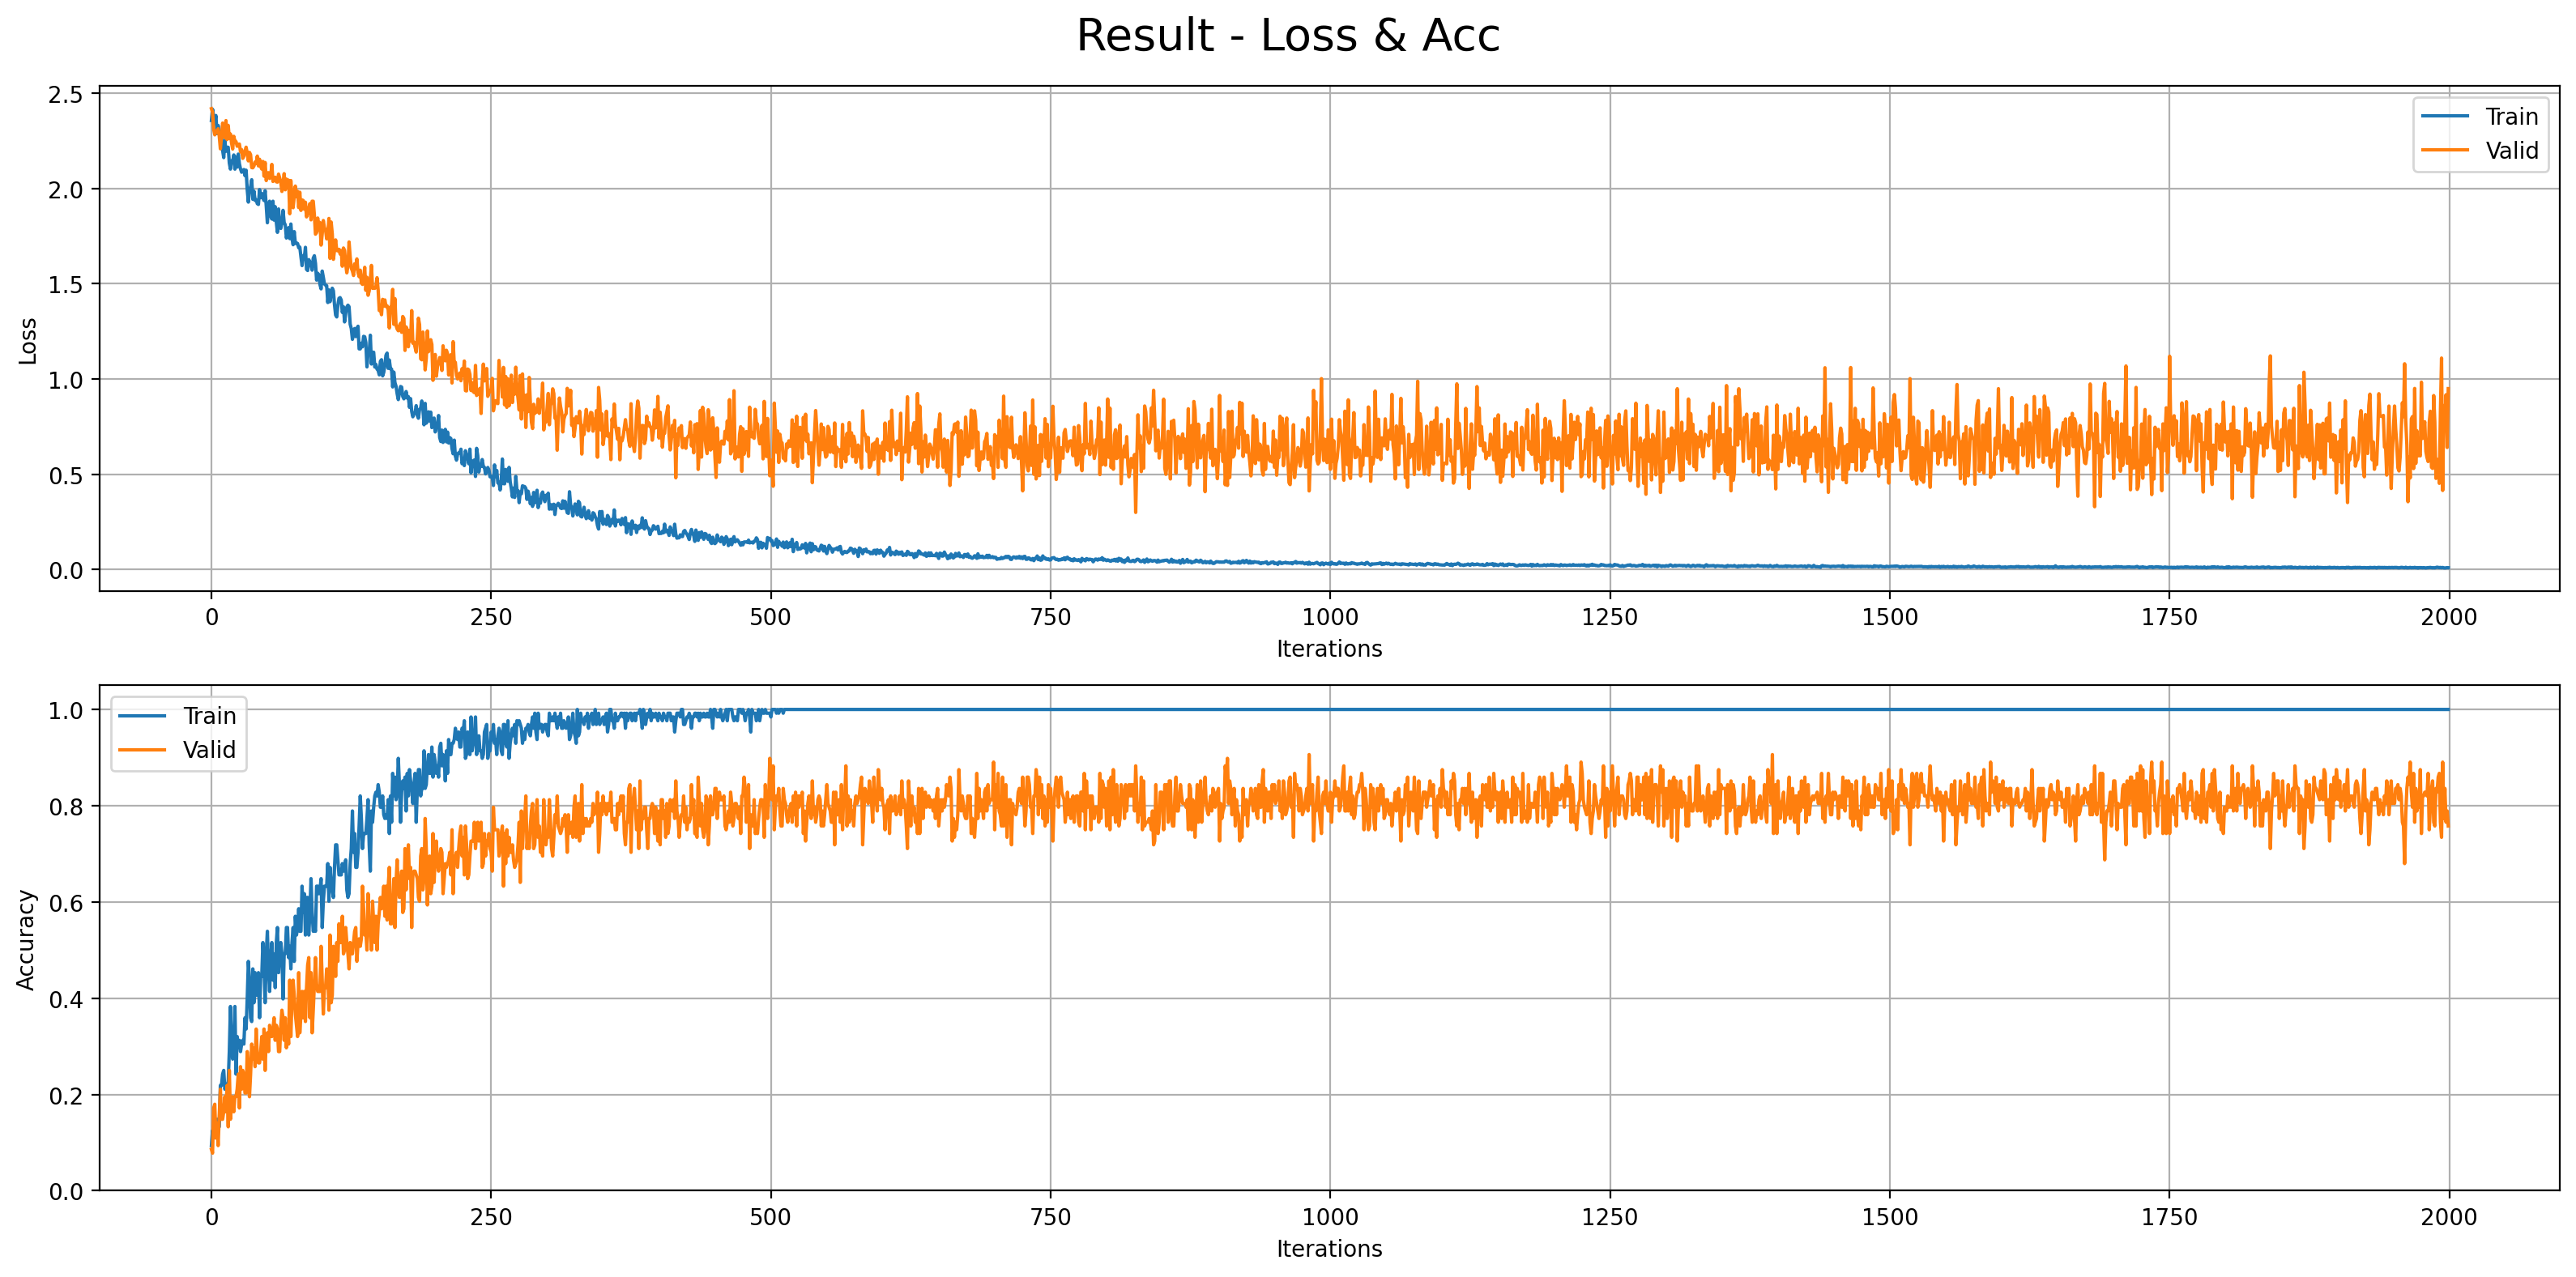

In [19]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=False,
    use_batchnorm=False,
    weight_decay_lambda=0,
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_base = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_base.run()

# 결과 시각화
trainer_base.show_results()

[Elpased Time: 0:00:00.004838] Iter:    0 Train Loss : 2.3073 Train Acc : 0.14 Valid Loss : 2.3078 Valid Acc : 0.05 
[Elpased Time: 0:00:00.362806] Iter:  100 Train Loss : 2.3054 Train Acc : 0.09 Valid Loss : 2.3036 Valid Acc : 0.07 
[Elpased Time: 0:00:00.677922] Iter:  200 Train Loss : 2.2673 Train Acc : 0.15 Valid Loss : 2.2903 Valid Acc : 0.20 
[Elpased Time: 0:00:00.992520] Iter:  300 Train Loss : 2.2560 Train Acc : 0.19 Valid Loss : 2.2858 Valid Acc : 0.18 
[Elpased Time: 0:00:01.306769] Iter:  400 Train Loss : 2.2278 Train Acc : 0.17 Valid Loss : 2.2765 Valid Acc : 0.14 
[Elpased Time: 0:00:01.661015] Iter:  500 Train Loss : 2.2349 Train Acc : 0.17 Valid Loss : 2.2710 Valid Acc : 0.20 
[Elpased Time: 0:00:01.977128] Iter:  600 Train Loss : 2.2764 Train Acc : 0.12 Valid Loss : 2.2943 Valid Acc : 0.21 
[Elpased Time: 0:00:02.309096] Iter:  700 Train Loss : 2.2397 Train Acc : 0.19 Valid Loss : 2.2559 Valid Acc : 0.20 
[Elpased Time: 0:00:02.626733] Iter:  800 Train Loss : 2.1874 Tr

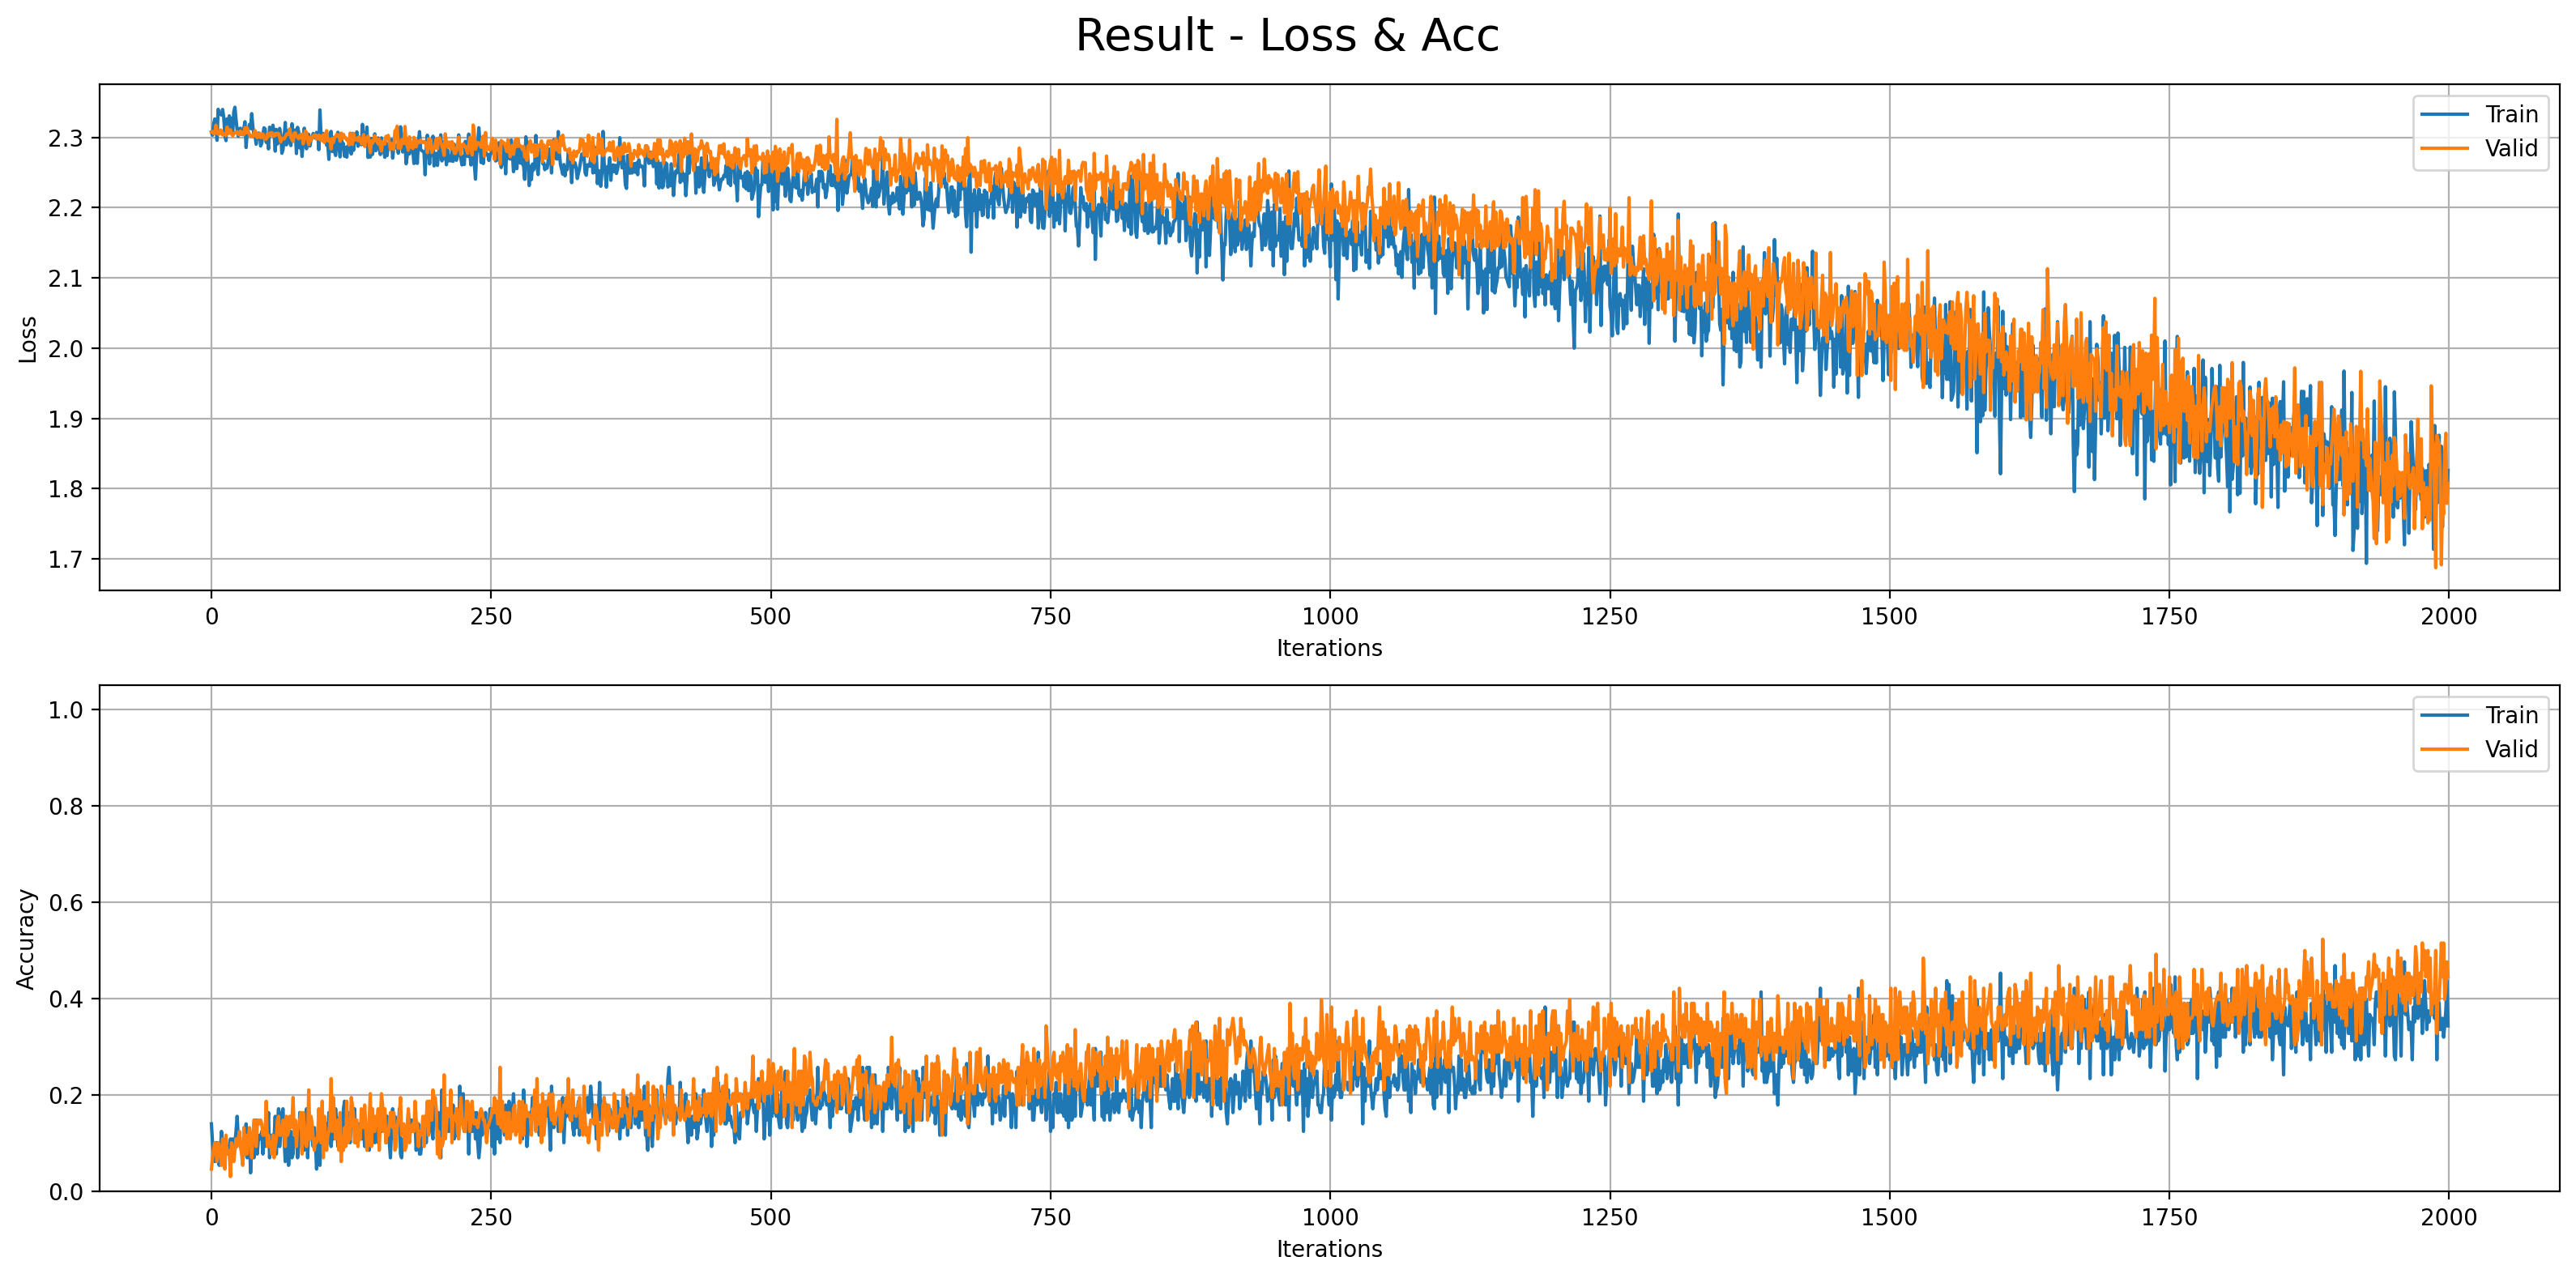

In [20]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,  # 드롭아웃을 사용해봅시다.
    dropout_ratio=0.5, # 비율을 다양하게 바꿔 실험해봅시다.
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_dropout = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_dropout.run()

# 결과 시각화
trainer_dropout.show_results()

[Elpased Time: 0:00:00.003722] Iter:    0 Train Loss : 2.3013 Train Acc : 0.08 Valid Loss : 2.3024 Valid Acc : 0.07 
[Elpased Time: 0:00:00.329576] Iter:  100 Train Loss : 2.2941 Train Acc : 0.12 Valid Loss : 2.3018 Valid Acc : 0.07 
[Elpased Time: 0:00:00.653808] Iter:  200 Train Loss : 2.2892 Train Acc : 0.15 Valid Loss : 2.2986 Valid Acc : 0.17 
[Elpased Time: 0:00:01.037621] Iter:  300 Train Loss : 2.2857 Train Acc : 0.16 Valid Loss : 2.2989 Valid Acc : 0.18 
[Elpased Time: 0:00:01.353769] Iter:  400 Train Loss : 2.2885 Train Acc : 0.15 Valid Loss : 2.3025 Valid Acc : 0.19 
[Elpased Time: 0:00:01.669068] Iter:  500 Train Loss : 2.2675 Train Acc : 0.17 Valid Loss : 2.3048 Valid Acc : 0.14 
[Elpased Time: 0:00:01.984779] Iter:  600 Train Loss : 2.2672 Train Acc : 0.19 Valid Loss : 2.3051 Valid Acc : 0.15 
[Elpased Time: 0:00:02.316367] Iter:  700 Train Loss : 2.2574 Train Acc : 0.16 Valid Loss : 2.3319 Valid Acc : 0.12 
[Elpased Time: 0:00:02.635215] Iter:  800 Train Loss : 2.2697 Tr

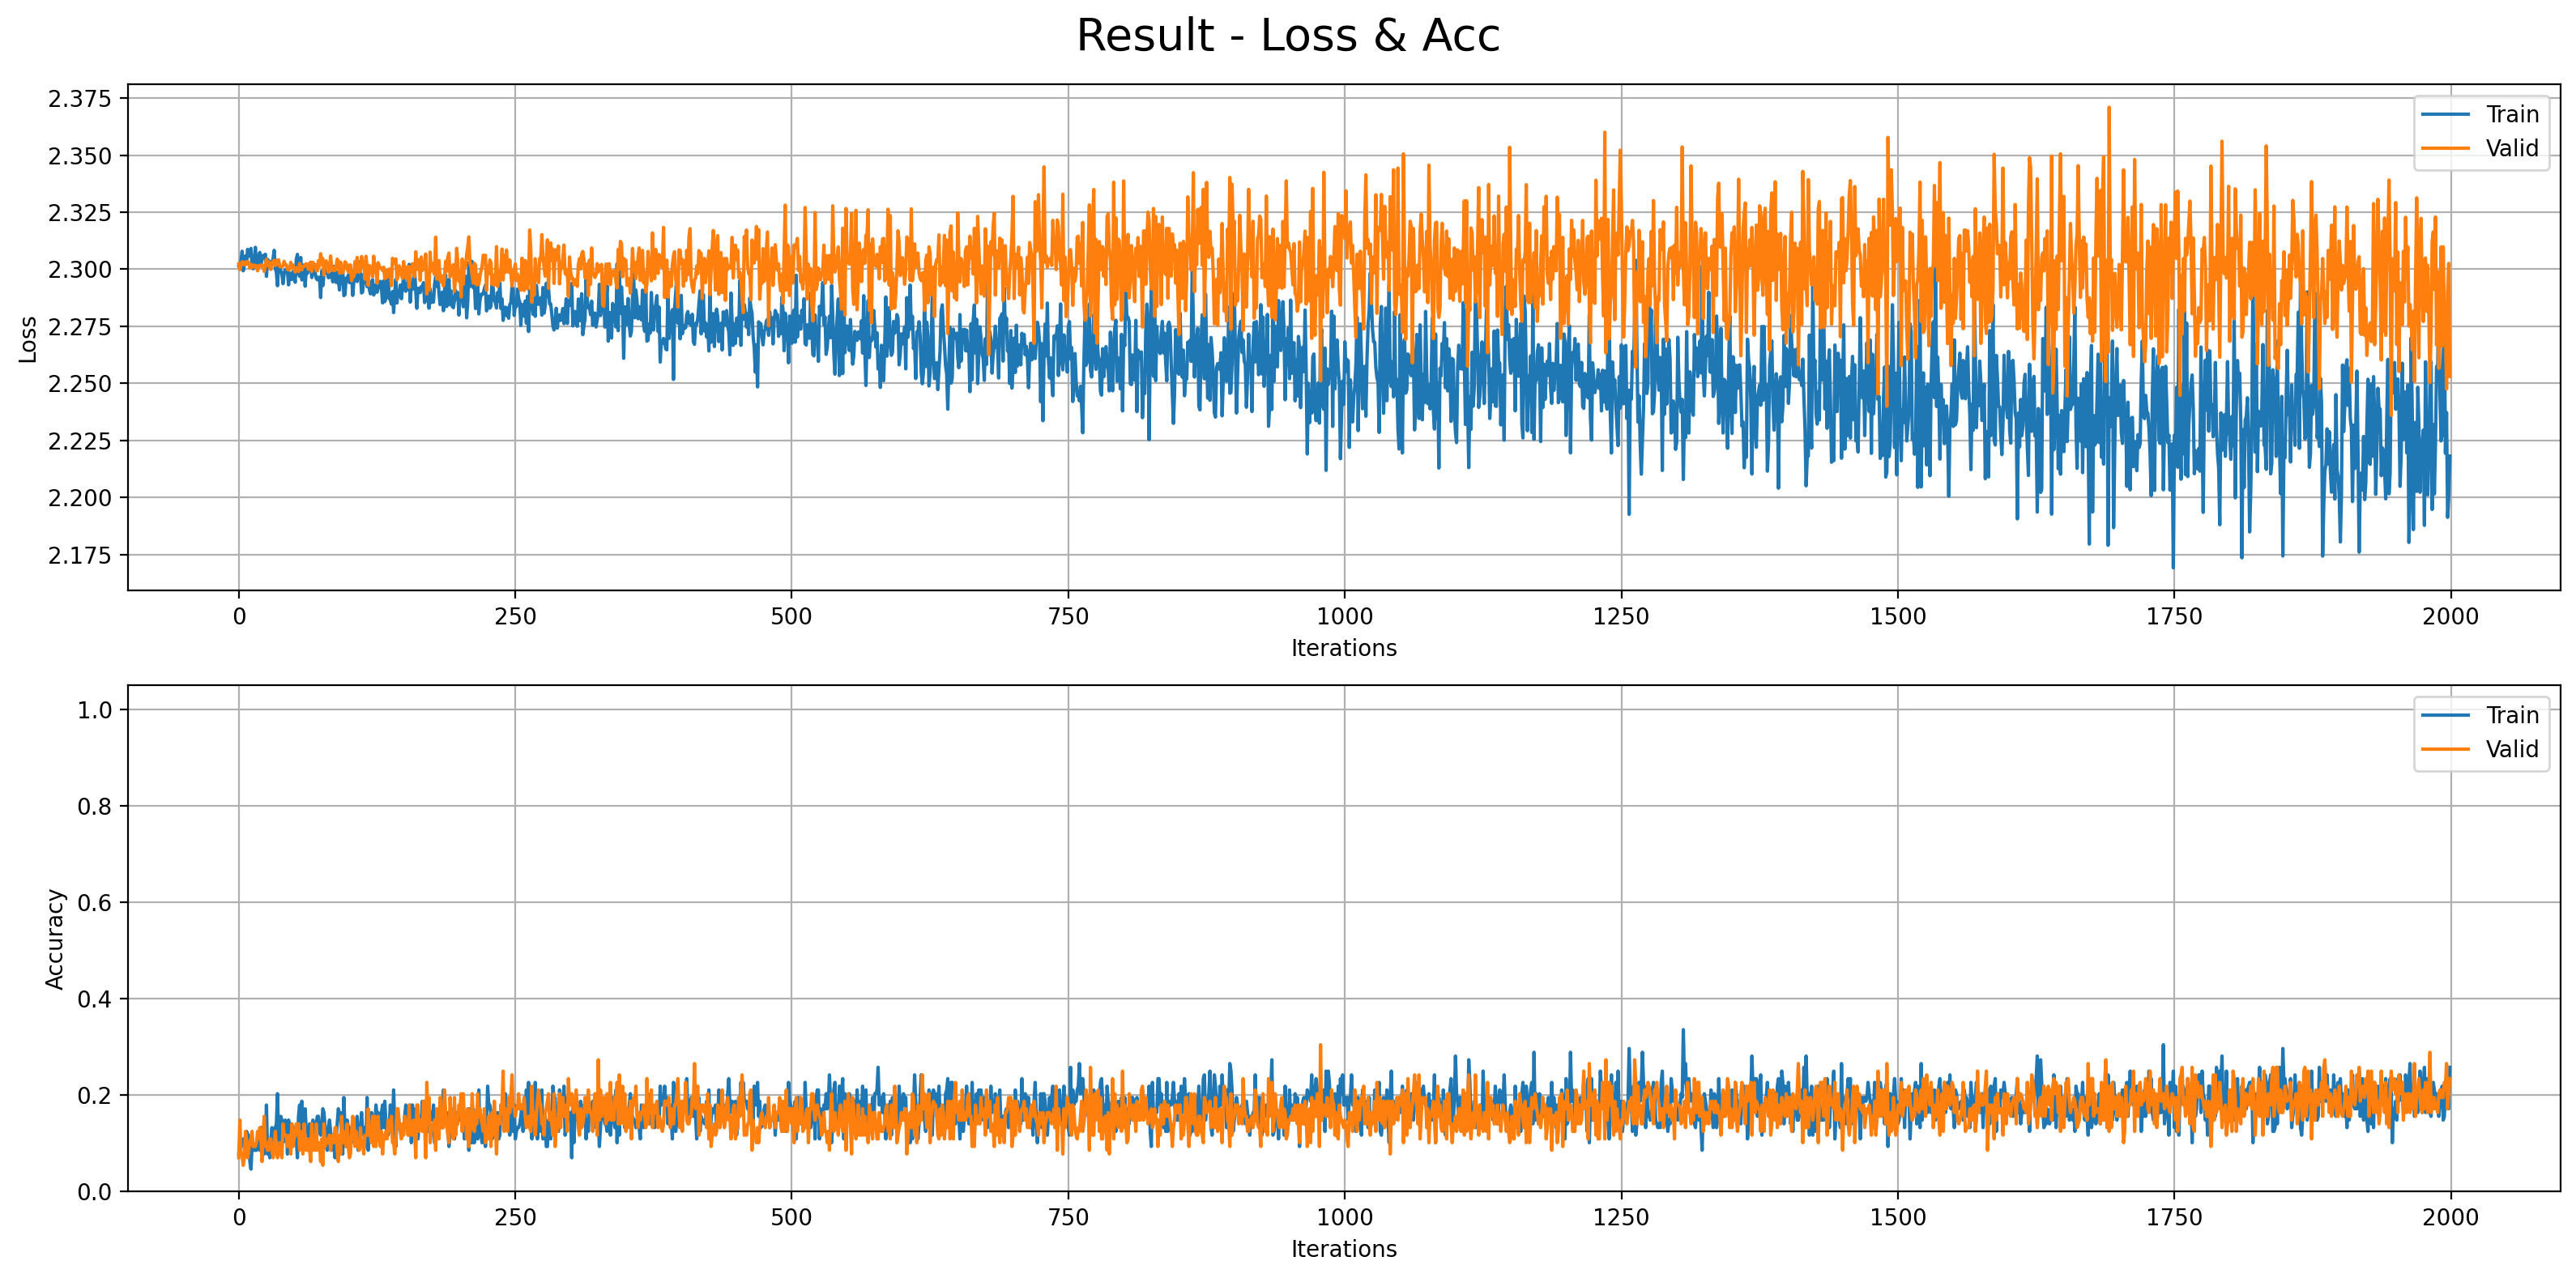

In [21]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='xavier', ## 가중치 초기화
    activation='relu',  # sigmoid 였다면 다를까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_xavier = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_xavier.run()

# 결과 시각화
trainer_xavier.show_results()

[Elpased Time: 0:00:00.004578] Iter:    0 Train Loss : 2.2834 Train Acc : 0.12 Valid Loss : 2.2993 Valid Acc : 0.11 
[Elpased Time: 0:00:00.340508] Iter:  100 Train Loss : 2.3148 Train Acc : 0.10 Valid Loss : 2.3013 Valid Acc : 0.08 
[Elpased Time: 0:00:00.710105] Iter:  200 Train Loss : 2.2652 Train Acc : 0.23 Valid Loss : 2.2859 Valid Acc : 0.16 
[Elpased Time: 0:00:01.027256] Iter:  300 Train Loss : 2.2612 Train Acc : 0.10 Valid Loss : 2.3053 Valid Acc : 0.18 
[Elpased Time: 0:00:01.344294] Iter:  400 Train Loss : 2.2218 Train Acc : 0.20 Valid Loss : 2.2869 Valid Acc : 0.16 
[Elpased Time: 0:00:01.660686] Iter:  500 Train Loss : 2.2679 Train Acc : 0.18 Valid Loss : 2.2771 Valid Acc : 0.20 
[Elpased Time: 0:00:01.976730] Iter:  600 Train Loss : 2.2425 Train Acc : 0.20 Valid Loss : 2.2569 Valid Acc : 0.20 
[Elpased Time: 0:00:02.312317] Iter:  700 Train Loss : 2.1900 Train Acc : 0.17 Valid Loss : 2.2554 Valid Acc : 0.13 
[Elpased Time: 0:00:02.700878] Iter:  800 Train Loss : 2.1916 Tr

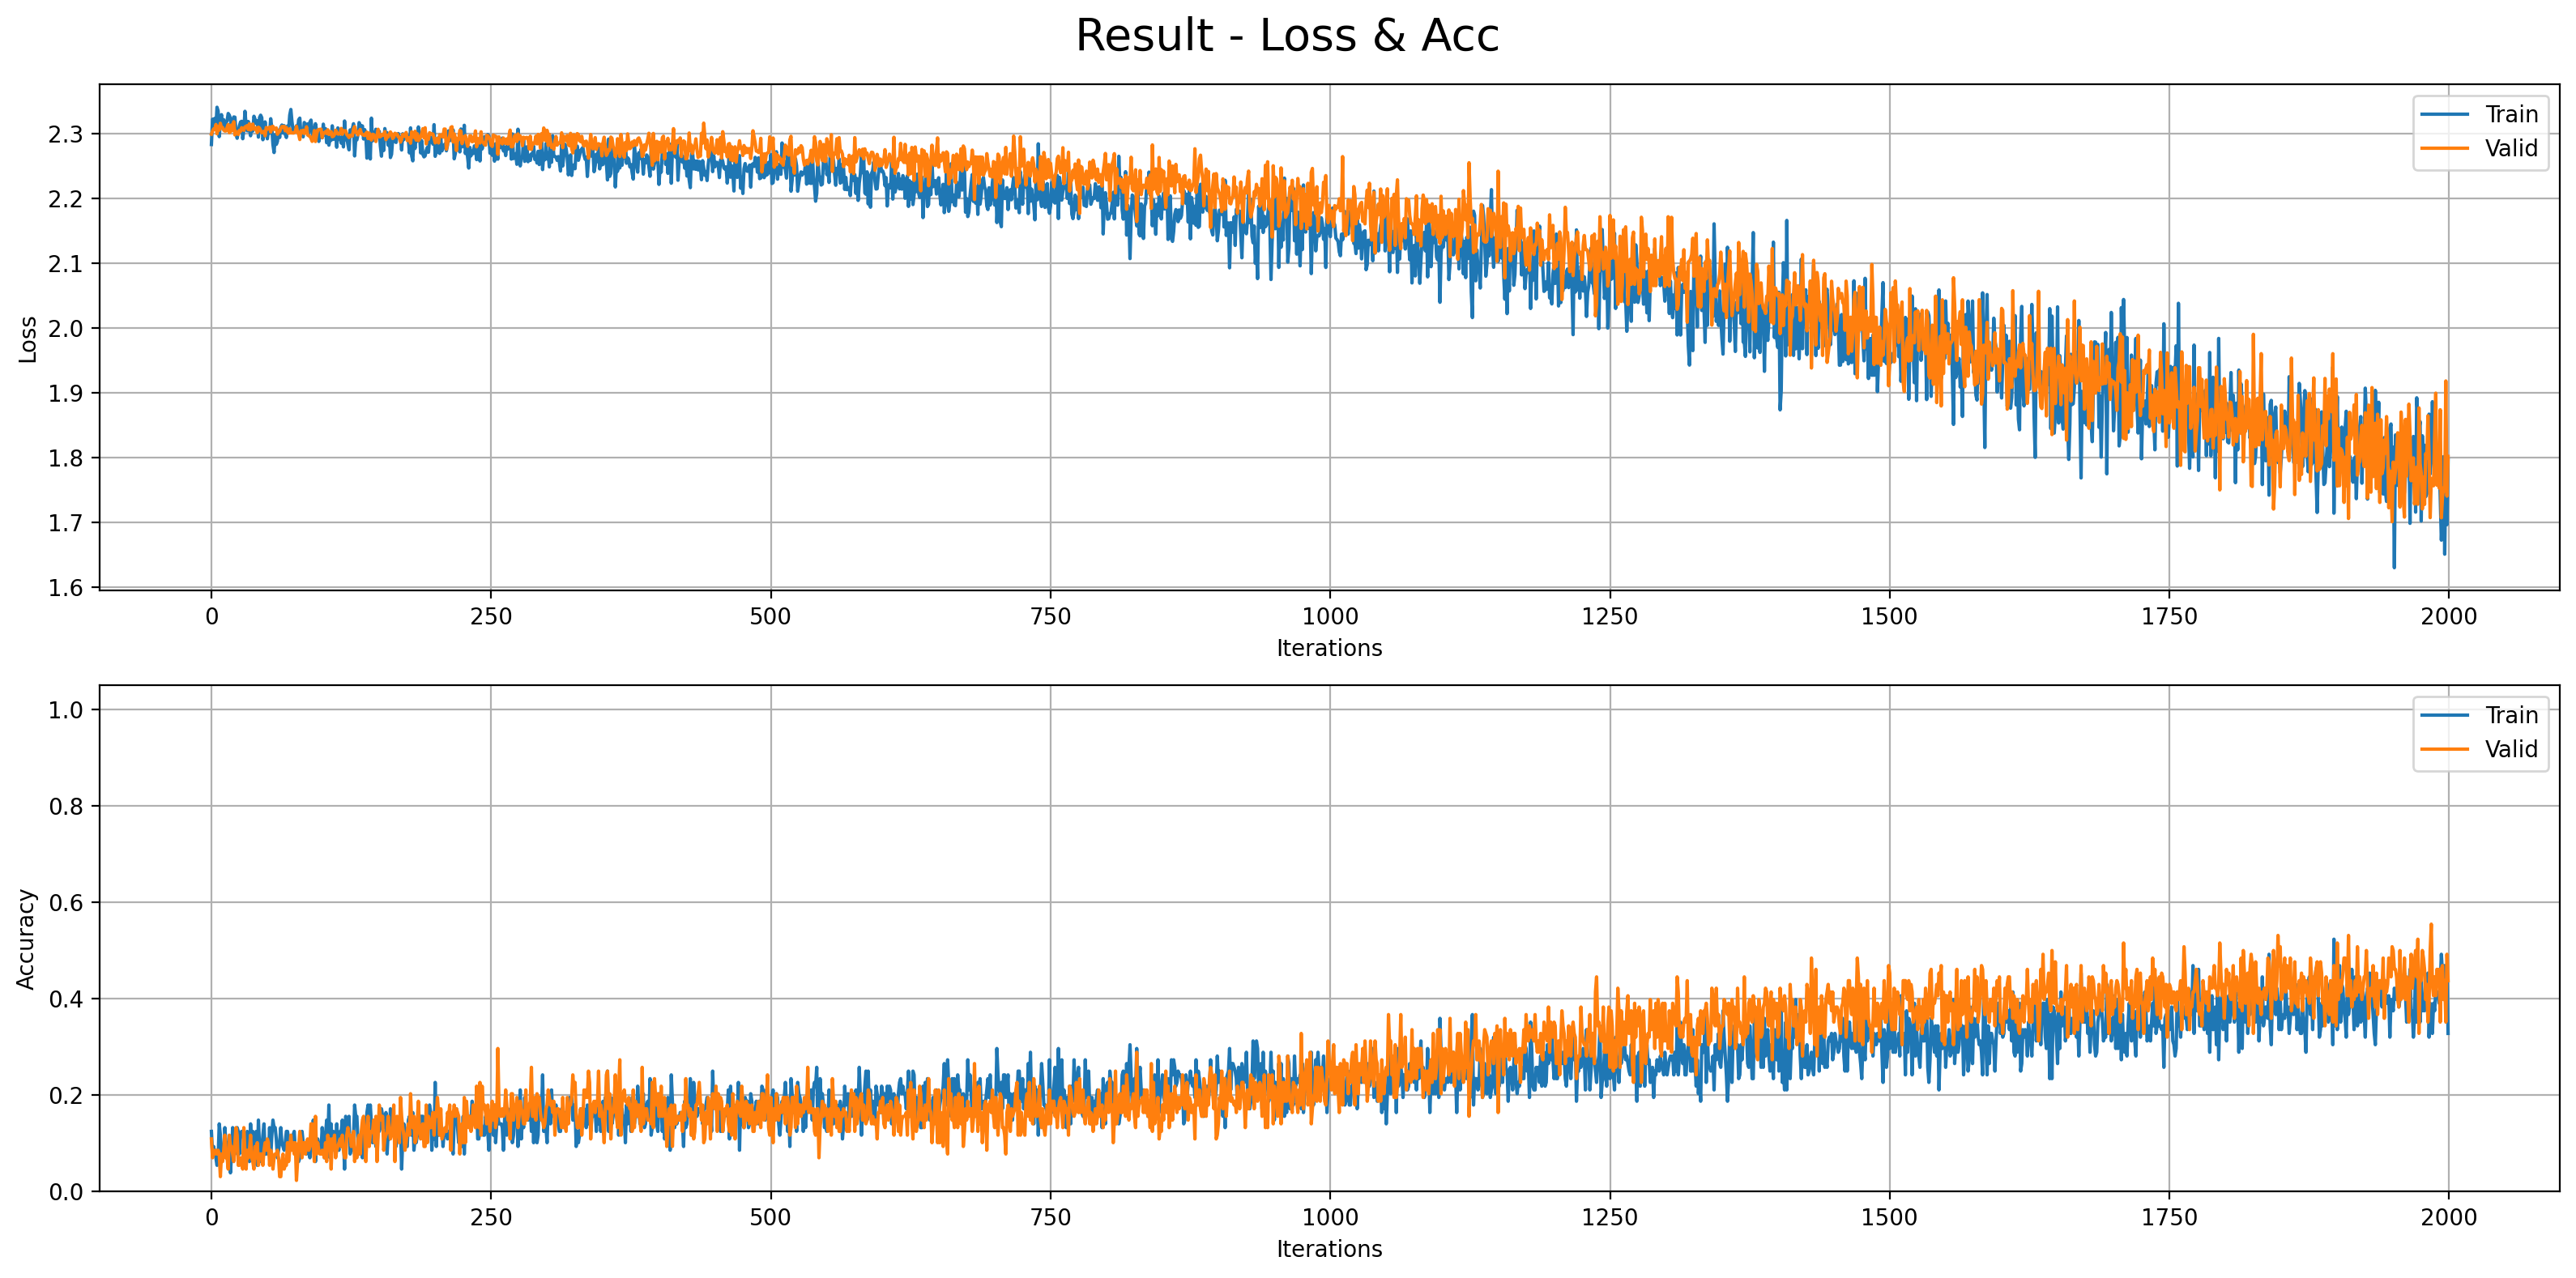

In [22]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_dropout=True,
    dropout_ratio=0.5,
    weight_init_std='he',
    activation='relu', # sigmoid 였다면 다를까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_he = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_he.run()

# 결과 시각화
trainer_he.show_results()

[Elpased Time: 0:00:00.007303] Iter:    0 Train Loss : 2.4387 Train Acc : 0.12 Valid Loss : 2.3373 Valid Acc : 0.16 
[Elpased Time: 0:00:00.394753] Iter:  100 Train Loss : 2.2209 Train Acc : 0.23 Valid Loss : 1.9351 Valid Acc : 0.37 
[Elpased Time: 0:00:00.771479] Iter:  200 Train Loss : 2.1530 Train Acc : 0.22 Valid Loss : 1.7192 Valid Acc : 0.55 
[Elpased Time: 0:00:01.148173] Iter:  300 Train Loss : 2.0081 Train Acc : 0.25 Valid Loss : 1.6310 Valid Acc : 0.57 
[Elpased Time: 0:00:01.525557] Iter:  400 Train Loss : 1.8412 Train Acc : 0.39 Valid Loss : 1.4256 Valid Acc : 0.63 
[Elpased Time: 0:00:01.902457] Iter:  500 Train Loss : 1.6661 Train Acc : 0.50 Valid Loss : 1.3871 Valid Acc : 0.62 
[Elpased Time: 0:00:02.367591] Iter:  600 Train Loss : 1.6811 Train Acc : 0.41 Valid Loss : 1.2964 Valid Acc : 0.64 
[Elpased Time: 0:00:02.747870] Iter:  700 Train Loss : 1.6338 Train Acc : 0.45 Valid Loss : 1.1688 Valid Acc : 0.71 
[Elpased Time: 0:00:03.124647] Iter:  800 Train Loss : 1.3544 Tr

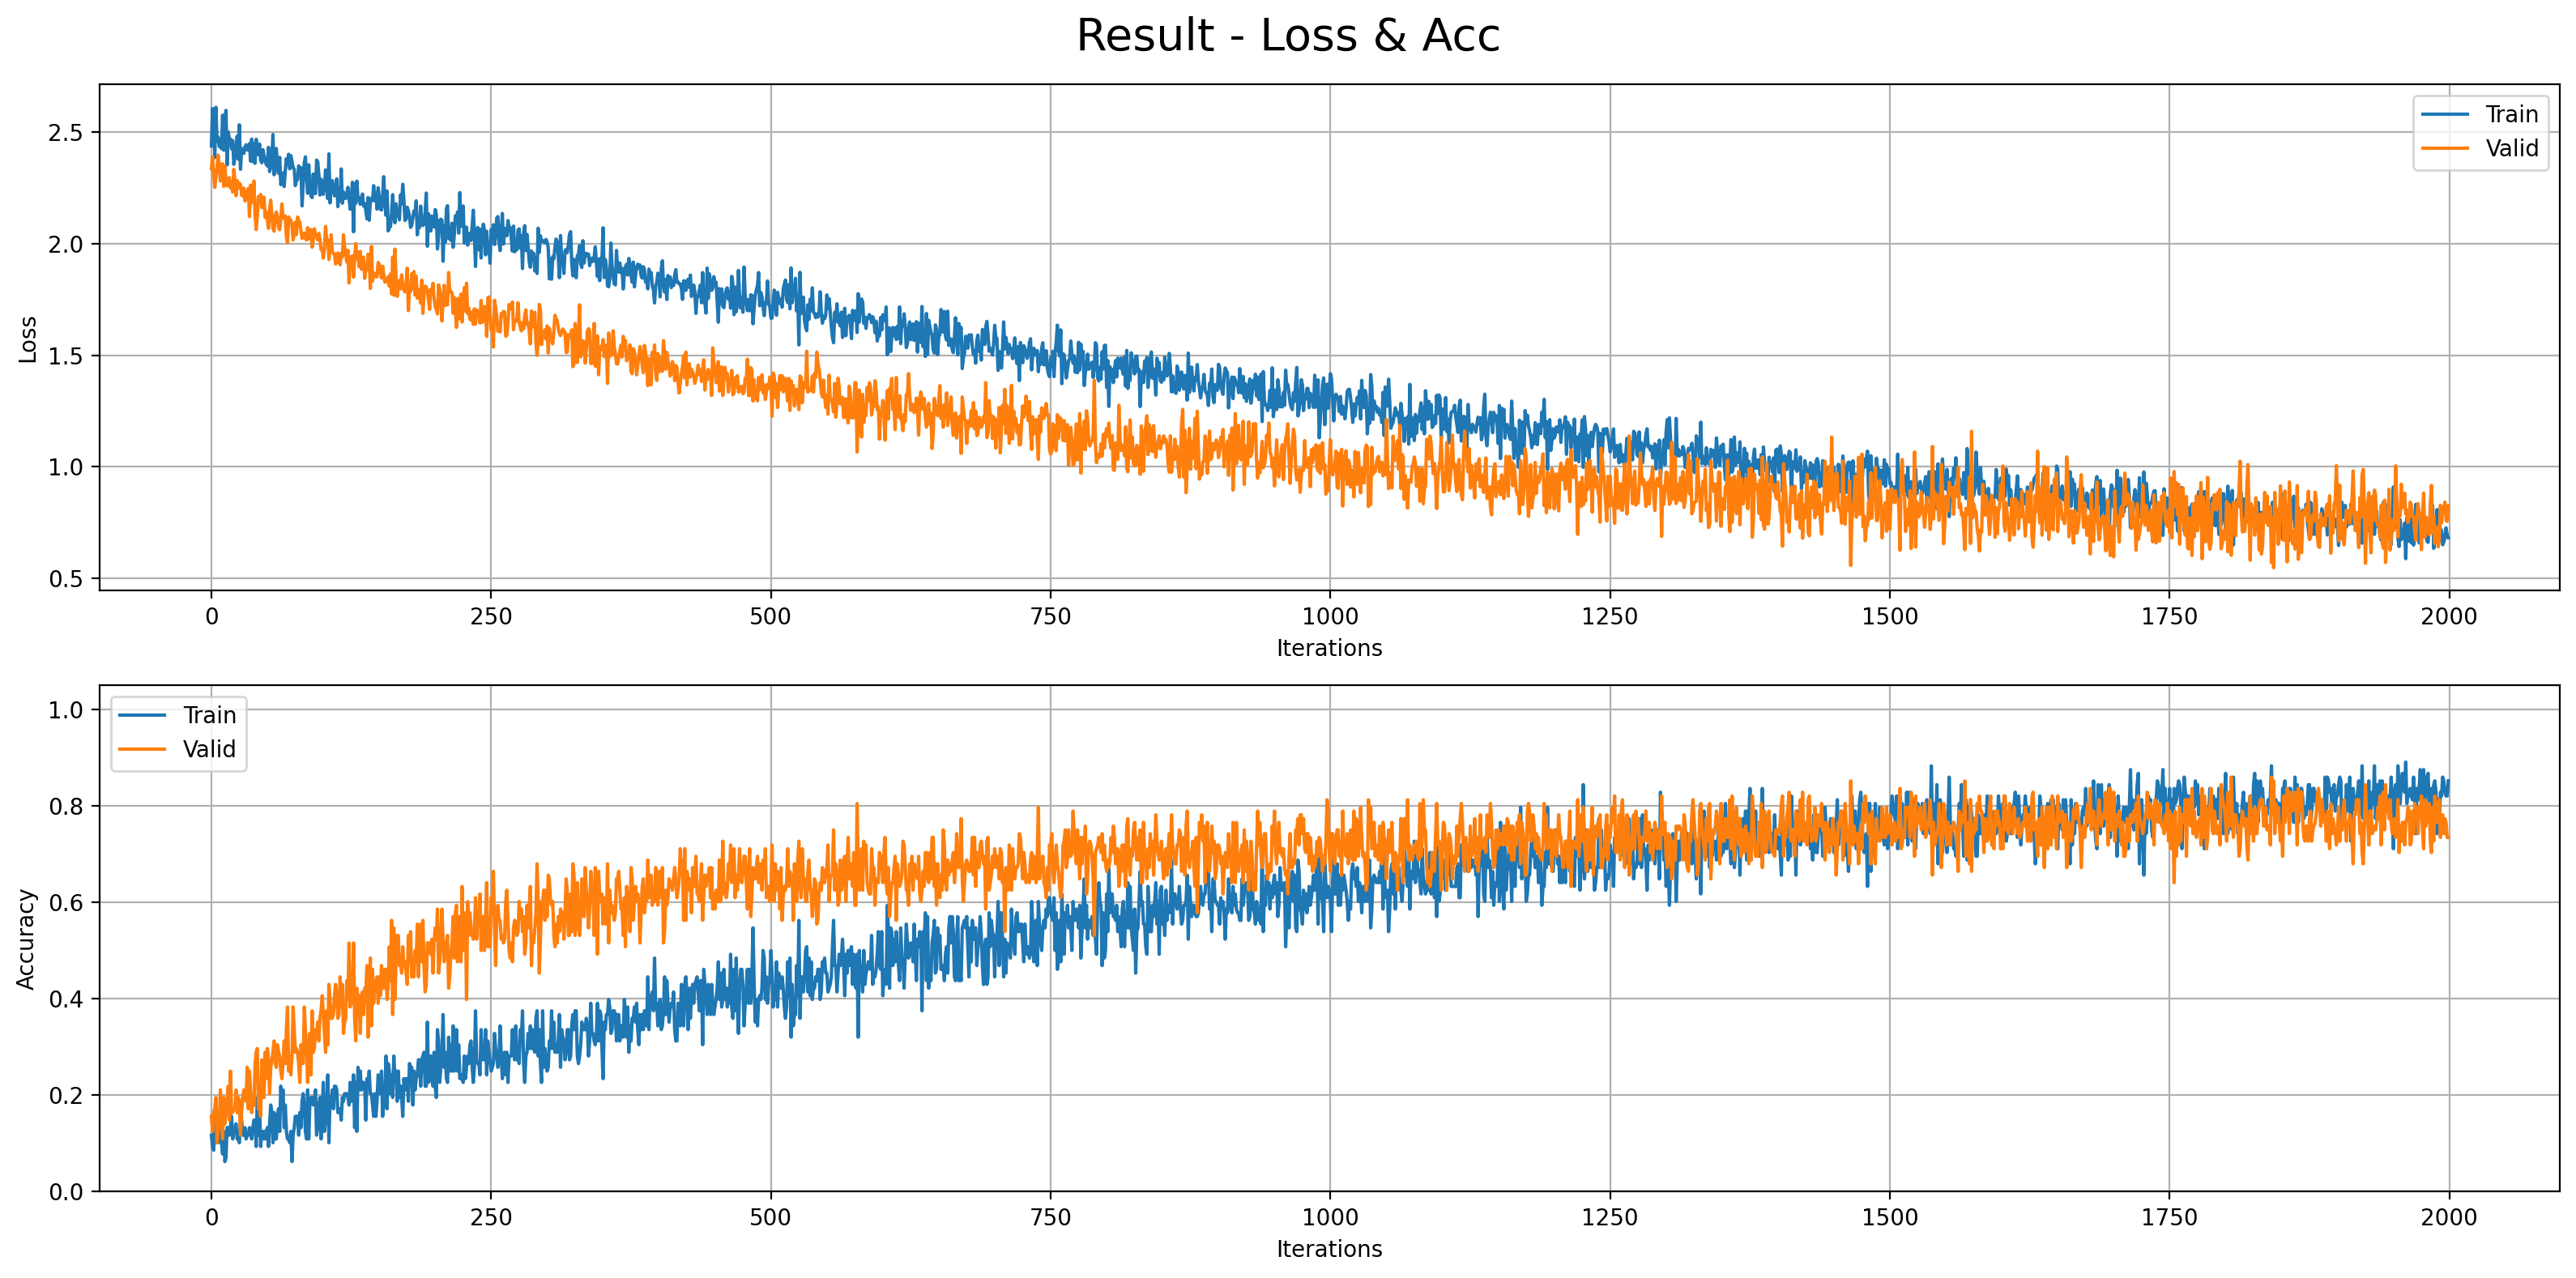

In [23]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
    use_batchnorm=True,  # 이번에는 배치 정규화를 사용해볼까요?
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_batchnorm = Trainer(
    X_train[:200], y_train[:200], # 과적합을 발생시키기 위해 모델에 비해 데이터셋이 부족하게 설정
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_batchnorm.run()

# 결과 시각화
trainer_batchnorm.show_results()

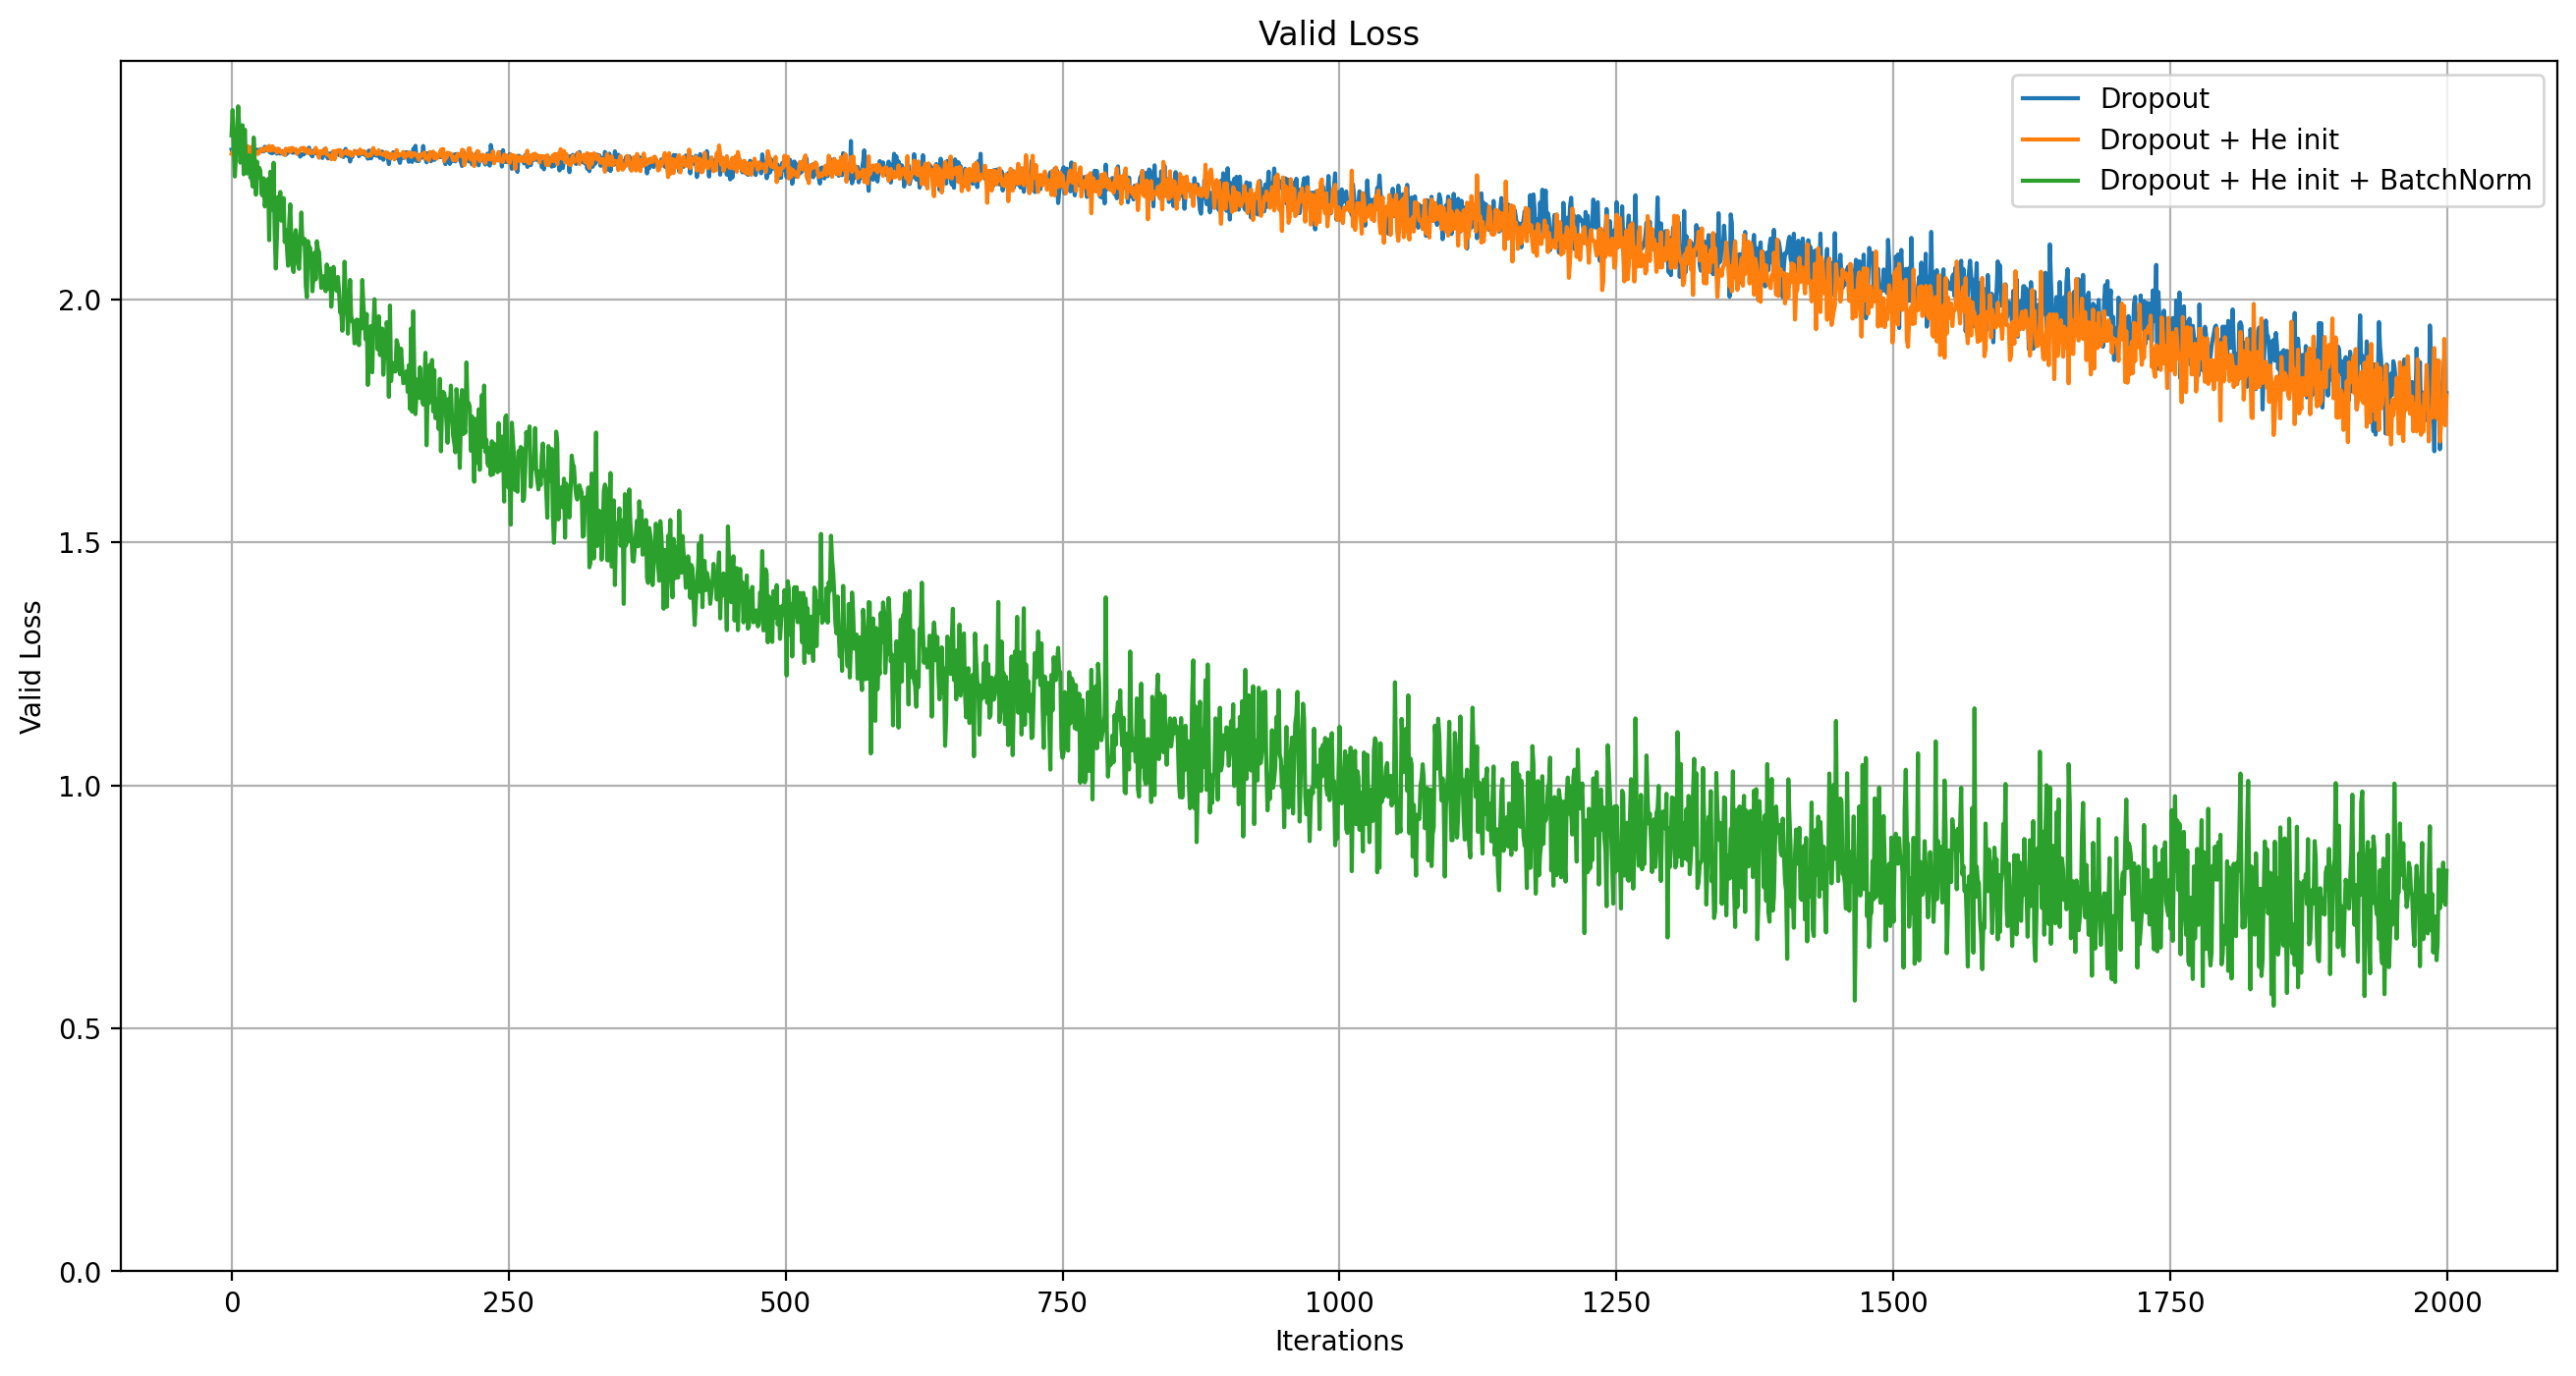

In [24]:
plt.figure(figsize=(16,8))

plt.plot(trainer_dropout.valid_loss_list)
plt.plot(trainer_he.valid_loss_list)
plt.plot(trainer_batchnorm.valid_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Loss')
plt.legend(['Dropout', 'Dropout + He init', 'Dropout + He init + BatchNorm'])
plt.ylim(0,)

plt.title('Valid Loss')
plt.grid(True)
plt.show()

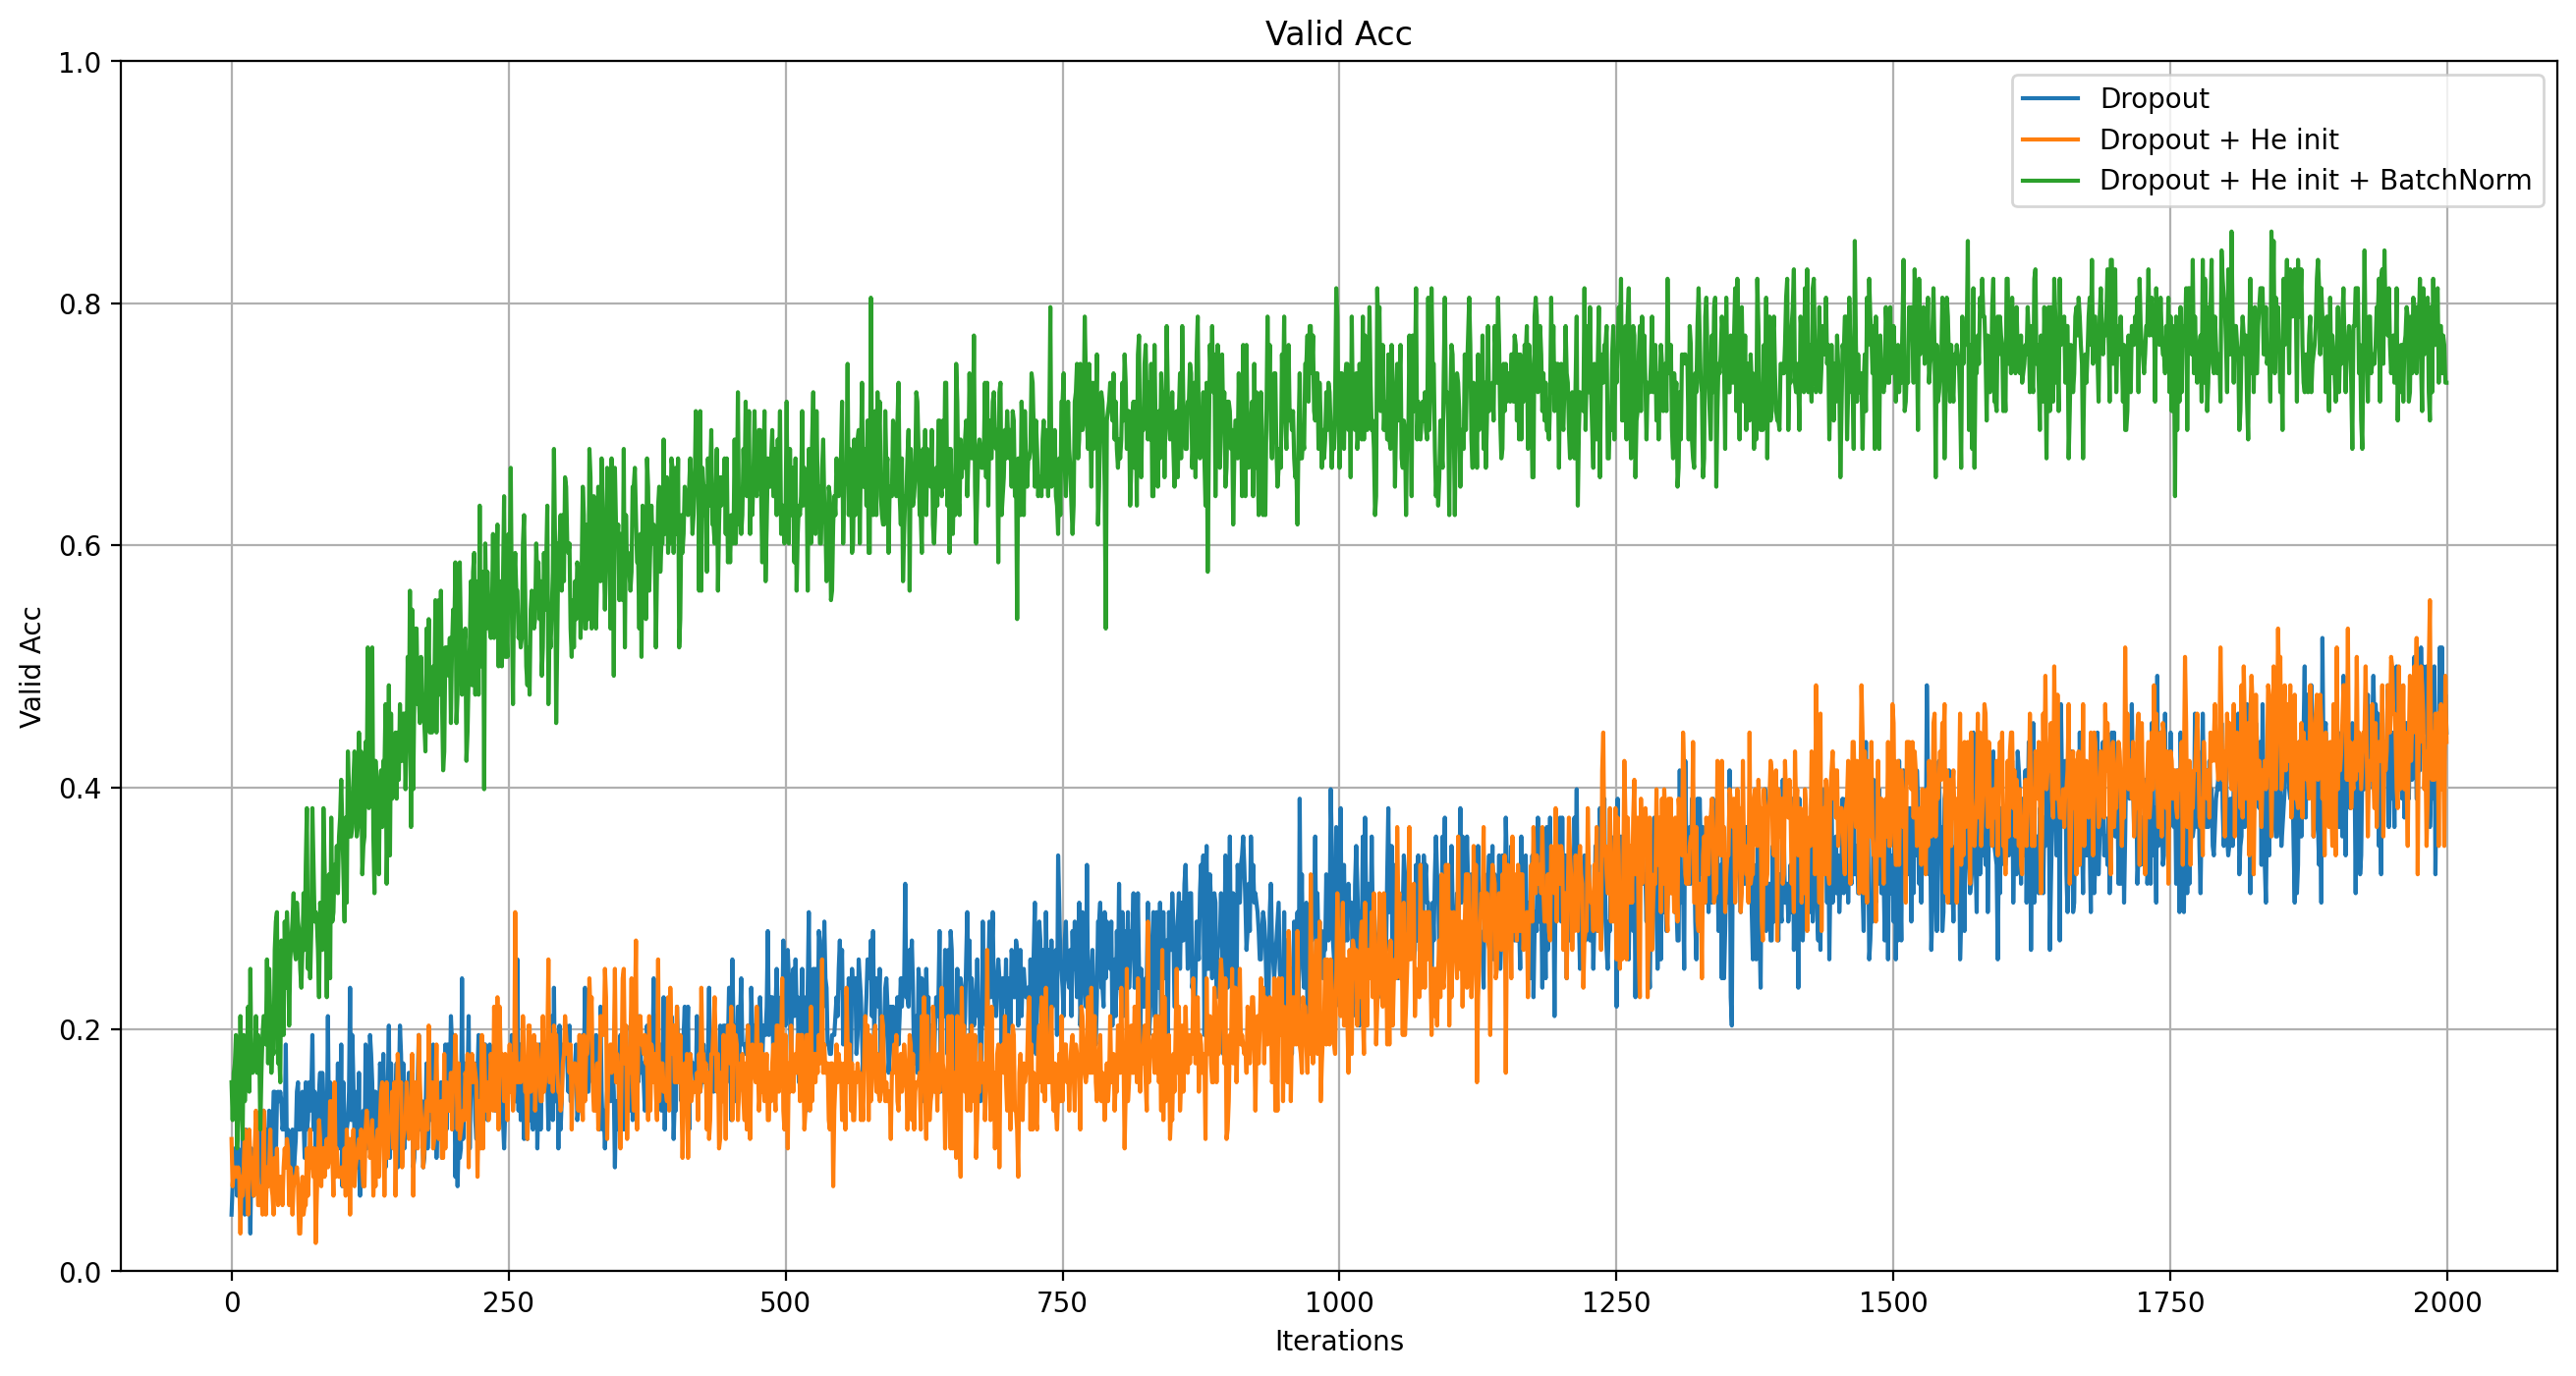

In [25]:
plt.figure(figsize=(16,8))

plt.plot(trainer_dropout.valid_acc_list)
plt.plot(trainer_he.valid_acc_list)
plt.plot(trainer_batchnorm.valid_acc_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Acc')
plt.legend(['Dropout', 'Dropout + He init', 'Dropout + He init + BatchNorm'])
plt.ylim(0,1)

plt.title('Valid Acc')
plt.grid(True)
plt.show()

[Elpased Time: 0:00:00.005860] Iter:    0 Train Loss : 2.6114 Train Acc : 0.07 Valid Loss : 2.2915 Valid Acc : 0.15 
[Elpased Time: 0:00:00.410025] Iter:  100 Train Loss : 2.3278 Train Acc : 0.17 Valid Loss : 2.0261 Valid Acc : 0.37 
[Elpased Time: 0:00:00.797591] Iter:  200 Train Loss : 2.1321 Train Acc : 0.23 Valid Loss : 1.7438 Valid Acc : 0.54 
[Elpased Time: 0:00:01.179606] Iter:  300 Train Loss : 1.9806 Train Acc : 0.34 Valid Loss : 1.5480 Valid Acc : 0.62 
[Elpased Time: 0:00:01.562421] Iter:  400 Train Loss : 1.9459 Train Acc : 0.27 Valid Loss : 1.3508 Valid Acc : 0.69 
[Elpased Time: 0:00:02.038138] Iter:  500 Train Loss : 1.8731 Train Acc : 0.34 Valid Loss : 1.1922 Valid Acc : 0.80 
[Elpased Time: 0:00:02.443210] Iter:  600 Train Loss : 1.8412 Train Acc : 0.40 Valid Loss : 1.2649 Valid Acc : 0.71 
[Elpased Time: 0:00:02.830557] Iter:  700 Train Loss : 1.6826 Train Acc : 0.42 Valid Loss : 1.0926 Valid Acc : 0.77 
[Elpased Time: 0:00:03.213461] Iter:  800 Train Loss : 1.6584 Tr

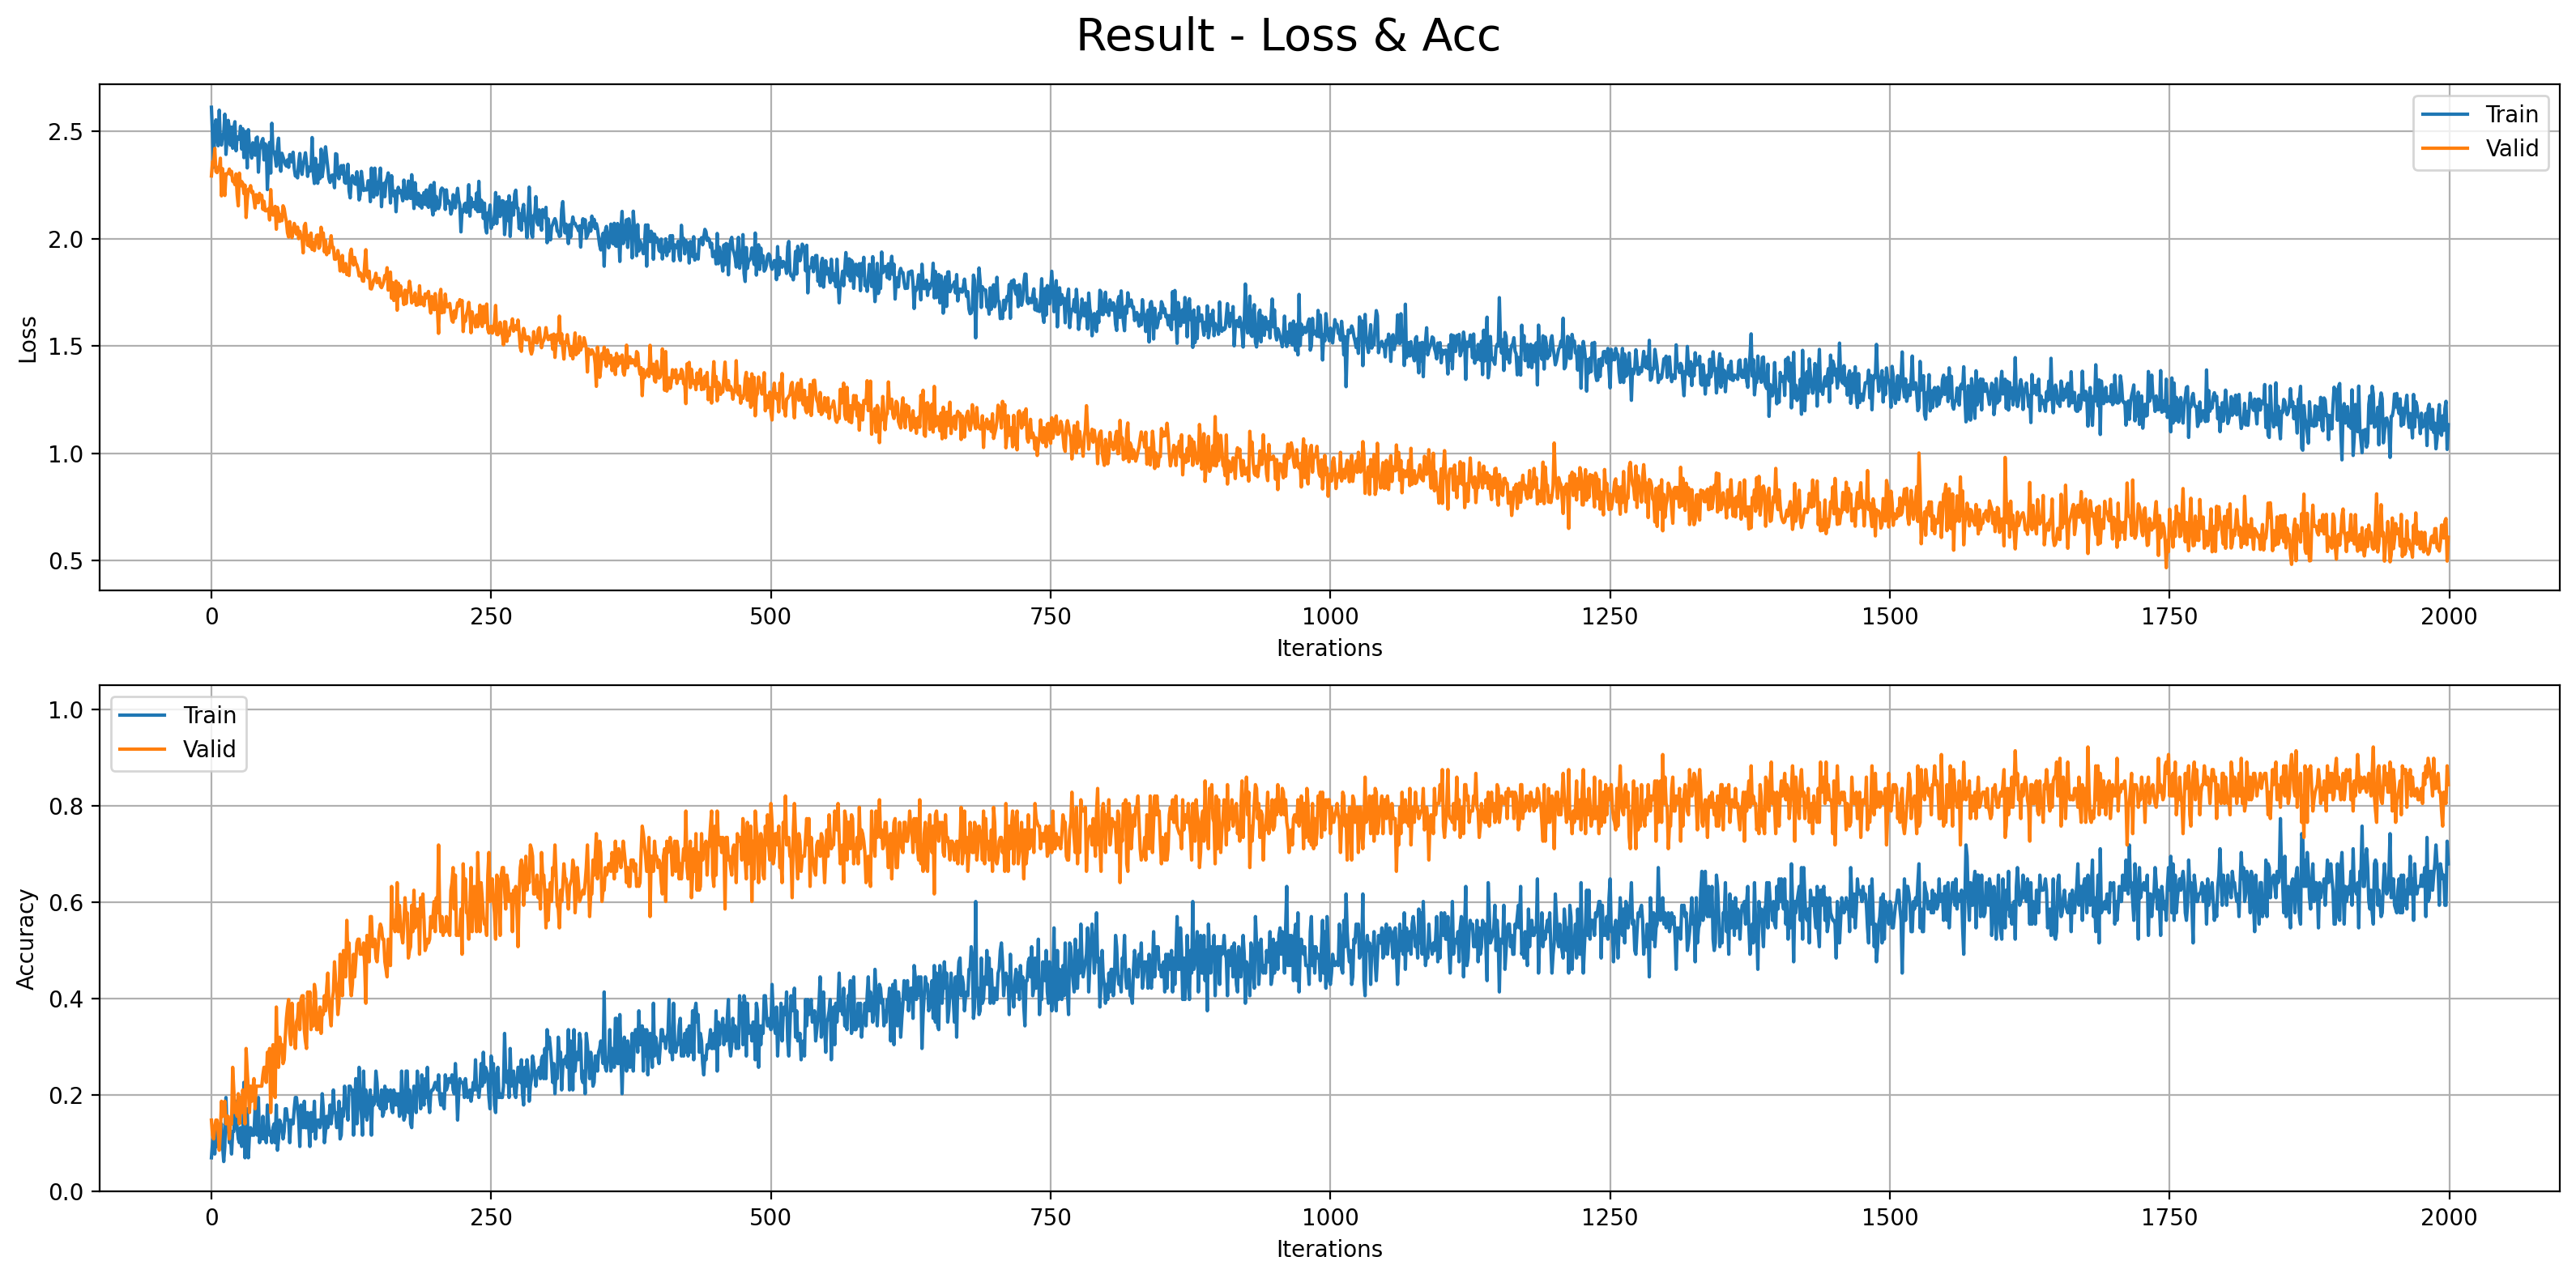

In [26]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = SGD(lr=0.01)

# 모델 학습 및 검증 시작
trainer_sgd = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_sgd.run()

# 결과 시각화
trainer_sgd.show_results()

In [27]:
class Momentum:

    # 생성자: 학습률(learning rate) 및 모멘텀 값 설정
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr                 # 학습률 설정
        self.momentum = momentum     # 모멘텀 설정
        self.v = None                # 속도 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 속도(v)를 파라미터와 동일한 형상의 0으로 초기화
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        # 모든 파라미터에 대해
        for key in params.keys():

            # 속도 업데이트
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]

            # 파라미터 업데이트
            params[key] += self.v[key]


[Elpased Time: 0:00:00.023870] Iter:    0 Train Loss : 2.5546 Train Acc : 0.06 Valid Loss : 2.3751 Valid Acc : 0.08 
[Elpased Time: 0:00:00.421985] Iter:  100 Train Loss : 1.8331 Train Acc : 0.38 Valid Loss : 1.0981 Valid Acc : 0.75 
[Elpased Time: 0:00:00.803818] Iter:  200 Train Loss : 1.2185 Train Acc : 0.68 Valid Loss : 0.7179 Valid Acc : 0.85 
[Elpased Time: 0:00:01.184366] Iter:  300 Train Loss : 0.9670 Train Acc : 0.67 Valid Loss : 0.4928 Valid Acc : 0.88 
[Elpased Time: 0:00:01.565820] Iter:  400 Train Loss : 0.8249 Train Acc : 0.73 Valid Loss : 0.3484 Valid Acc : 0.91 
[Elpased Time: 0:00:01.984889] Iter:  500 Train Loss : 0.8279 Train Acc : 0.74 Valid Loss : 0.3758 Valid Acc : 0.88 
[Elpased Time: 0:00:02.386675] Iter:  600 Train Loss : 0.8216 Train Acc : 0.75 Valid Loss : 0.2798 Valid Acc : 0.93 
[Elpased Time: 0:00:02.770639] Iter:  700 Train Loss : 0.6613 Train Acc : 0.82 Valid Loss : 0.2645 Valid Acc : 0.91 
[Elpased Time: 0:00:03.160774] Iter:  800 Train Loss : 0.7601 Tr

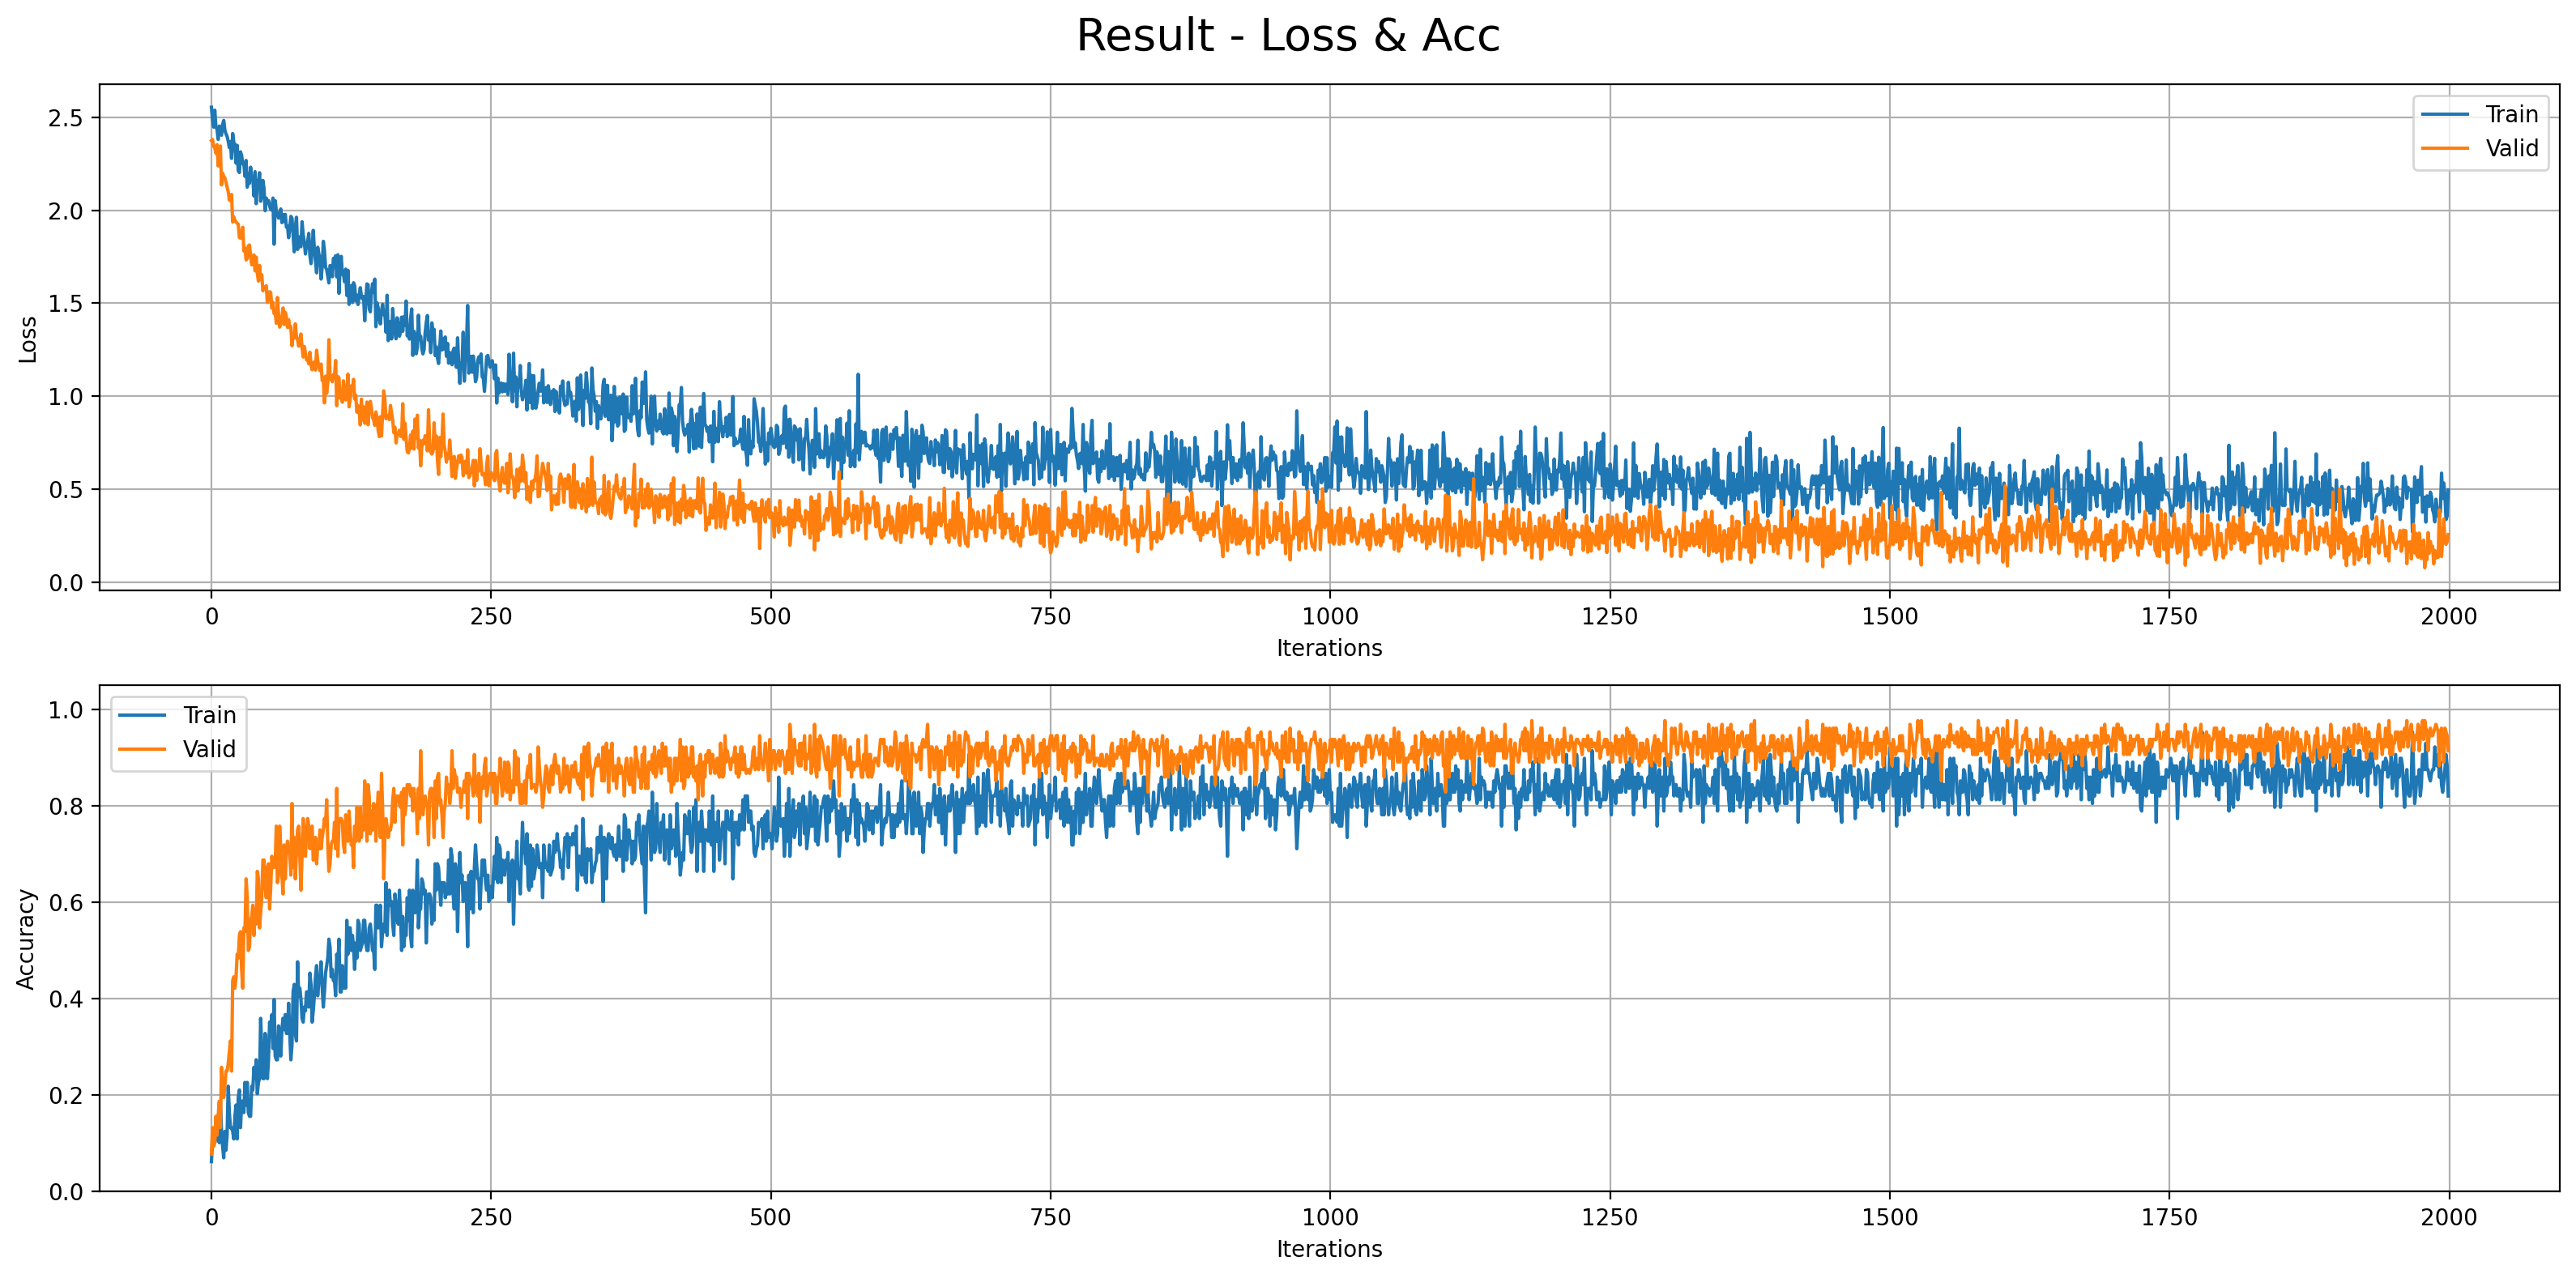

In [28]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Momentum(lr=0.01, momentum=0.9)

# 모델 학습 및 검증 시작
trainer_momentum = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_momentum.run()

# 결과 시각화
trainer_momentum.show_results()

In [29]:
class Nesterov:

    # 학습률(learning rate) 및 모멘텀 계수 설정
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr             # 학습률
        self.momentum = momentum # 모멘텀 계수
        self.v = None            # 속도

    # 파라미터 업데이트 함수
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # 현재 속도를 기반으로 예측된 위치 계산
            w_pred = params[key] + self.momentum * self.v[key]

            # 예측된 위치에서의 그래디언트 계산
            # 여기서는 간단하게 현재 위치에서의 그래디언트를 사용합니다.
            g = grads[key]

            # 속도 업데이트
            self.v[key] = self.momentum * self.v[key] - self.lr * g

            # 파라미터 업데이트
            params[key] += self.v[key]

[Elpased Time: 0:00:00.005869] Iter:    0 Train Loss : 2.5235 Train Acc : 0.11 Valid Loss : 2.4864 Valid Acc : 0.07 
[Elpased Time: 0:00:00.469232] Iter:  100 Train Loss : 1.8423 Train Acc : 0.42 Valid Loss : 1.1122 Valid Acc : 0.78 
[Elpased Time: 0:00:00.862160] Iter:  200 Train Loss : 1.2328 Train Acc : 0.61 Valid Loss : 0.6792 Valid Acc : 0.83 
[Elpased Time: 0:00:01.256595] Iter:  300 Train Loss : 1.1076 Train Acc : 0.65 Valid Loss : 0.4888 Valid Acc : 0.86 
[Elpased Time: 0:00:01.649493] Iter:  400 Train Loss : 0.8750 Train Acc : 0.72 Valid Loss : 0.4231 Valid Acc : 0.87 
[Elpased Time: 0:00:02.060000] Iter:  500 Train Loss : 0.7953 Train Acc : 0.77 Valid Loss : 0.5009 Valid Acc : 0.85 
[Elpased Time: 0:00:02.539543] Iter:  600 Train Loss : 0.6872 Train Acc : 0.79 Valid Loss : 0.5211 Valid Acc : 0.83 
[Elpased Time: 0:00:02.932216] Iter:  700 Train Loss : 0.8198 Train Acc : 0.78 Valid Loss : 0.3061 Valid Acc : 0.89 
[Elpased Time: 0:00:03.326082] Iter:  800 Train Loss : 0.7166 Tr

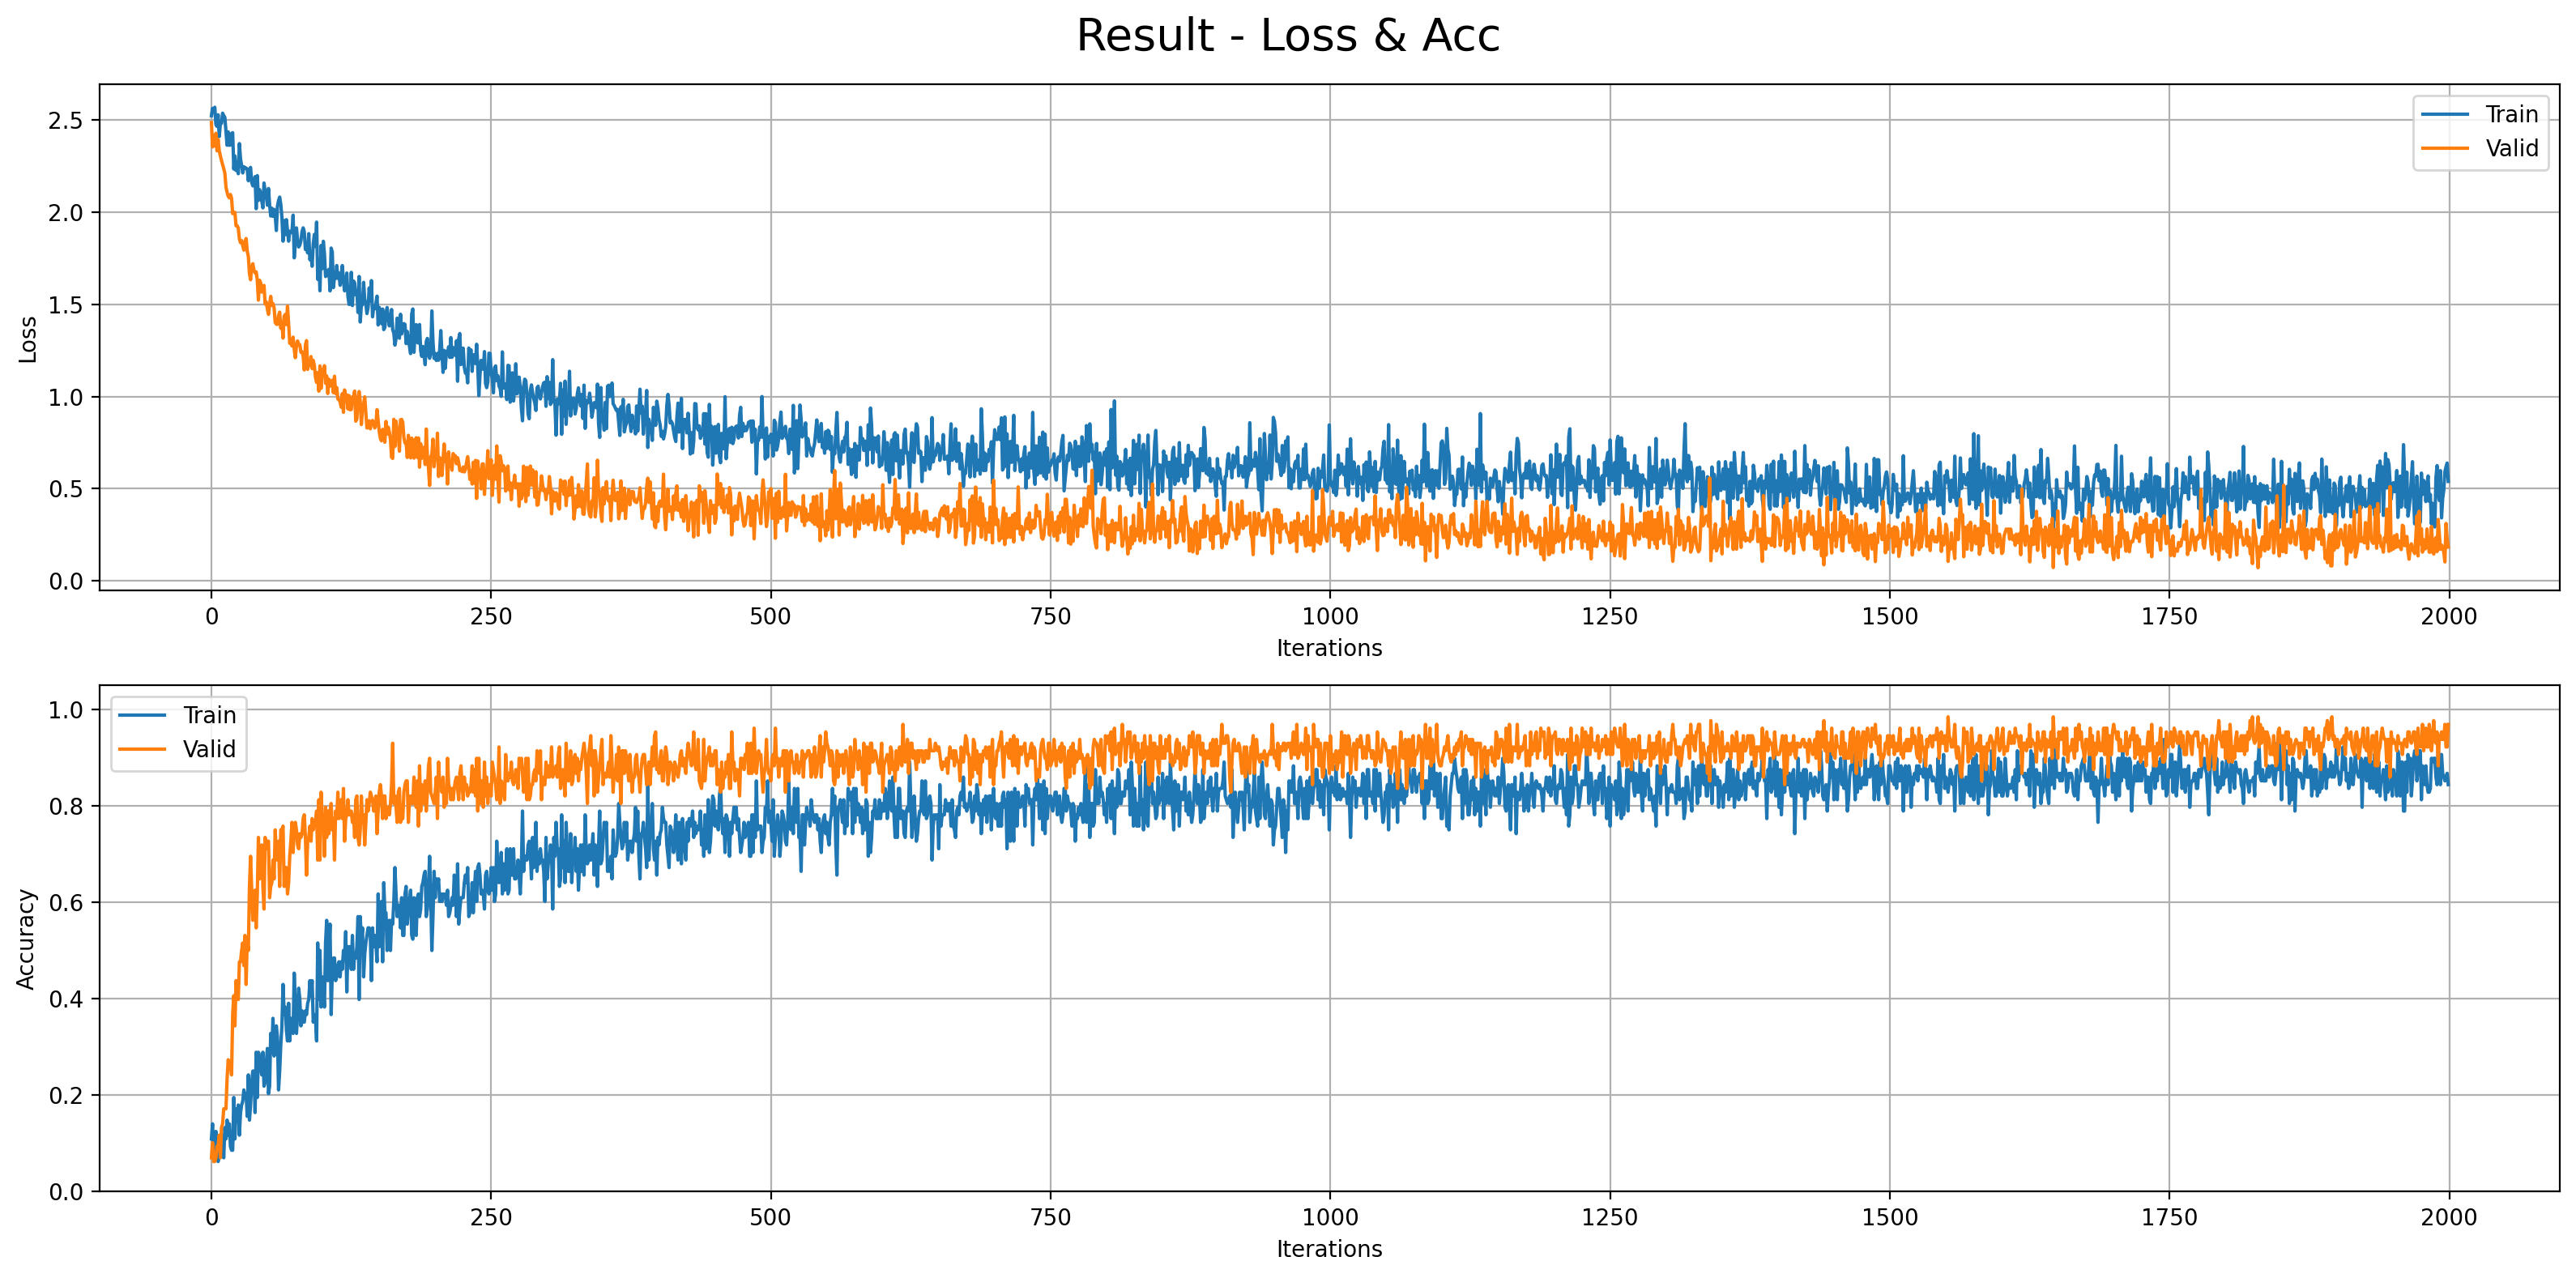

In [30]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Nesterov(lr=0.01, momentum=0.9)

# 모델 학습 및 검증 시작
trainer_nesterov = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_nesterov.run()

# 결과 시각화
trainer_nesterov.show_results()

In [31]:
class AdaGrad:

    # 학습률(learning rate) 설정
    def __init__(self, lr=0.01):
        self.lr = lr      # 학습률 설정
        self.h = None     # 이전 기울기의 제곱 합을 저장할 변수 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 h를 파라미터와 동일한 형상의 0으로 초기화
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # 기울기의 제곱 합을 h에 누적
            self.h[key] += grads[key] * grads[key]

            # 파라미터 업데이트 (AdaGrad 특징 부분)
            # 0으로 나누는 것을 방지하기 위한 작은 상수 추가
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

[Elpased Time: 0:00:00.023296] Iter:    0 Train Loss : 2.6186 Train Acc : 0.11 Valid Loss : 2.1367 Valid Acc : 0.17 
[Elpased Time: 0:00:00.450291] Iter:  100 Train Loss : 1.0395 Train Acc : 0.68 Valid Loss : 0.5007 Valid Acc : 0.88 
[Elpased Time: 0:00:00.851567] Iter:  200 Train Loss : 0.7150 Train Acc : 0.76 Valid Loss : 0.3642 Valid Acc : 0.93 
[Elpased Time: 0:00:01.251230] Iter:  300 Train Loss : 0.6158 Train Acc : 0.85 Valid Loss : 0.3214 Valid Acc : 0.90 
[Elpased Time: 0:00:01.651380] Iter:  400 Train Loss : 0.6521 Train Acc : 0.81 Valid Loss : 0.3982 Valid Acc : 0.88 
[Elpased Time: 0:00:02.095216] Iter:  500 Train Loss : 0.6505 Train Acc : 0.81 Valid Loss : 0.2728 Valid Acc : 0.93 
[Elpased Time: 0:00:02.516675] Iter:  600 Train Loss : 0.5756 Train Acc : 0.82 Valid Loss : 0.2730 Valid Acc : 0.91 
[Elpased Time: 0:00:02.917642] Iter:  700 Train Loss : 0.5484 Train Acc : 0.83 Valid Loss : 0.3150 Valid Acc : 0.92 
[Elpased Time: 0:00:03.317075] Iter:  800 Train Loss : 0.4173 Tr

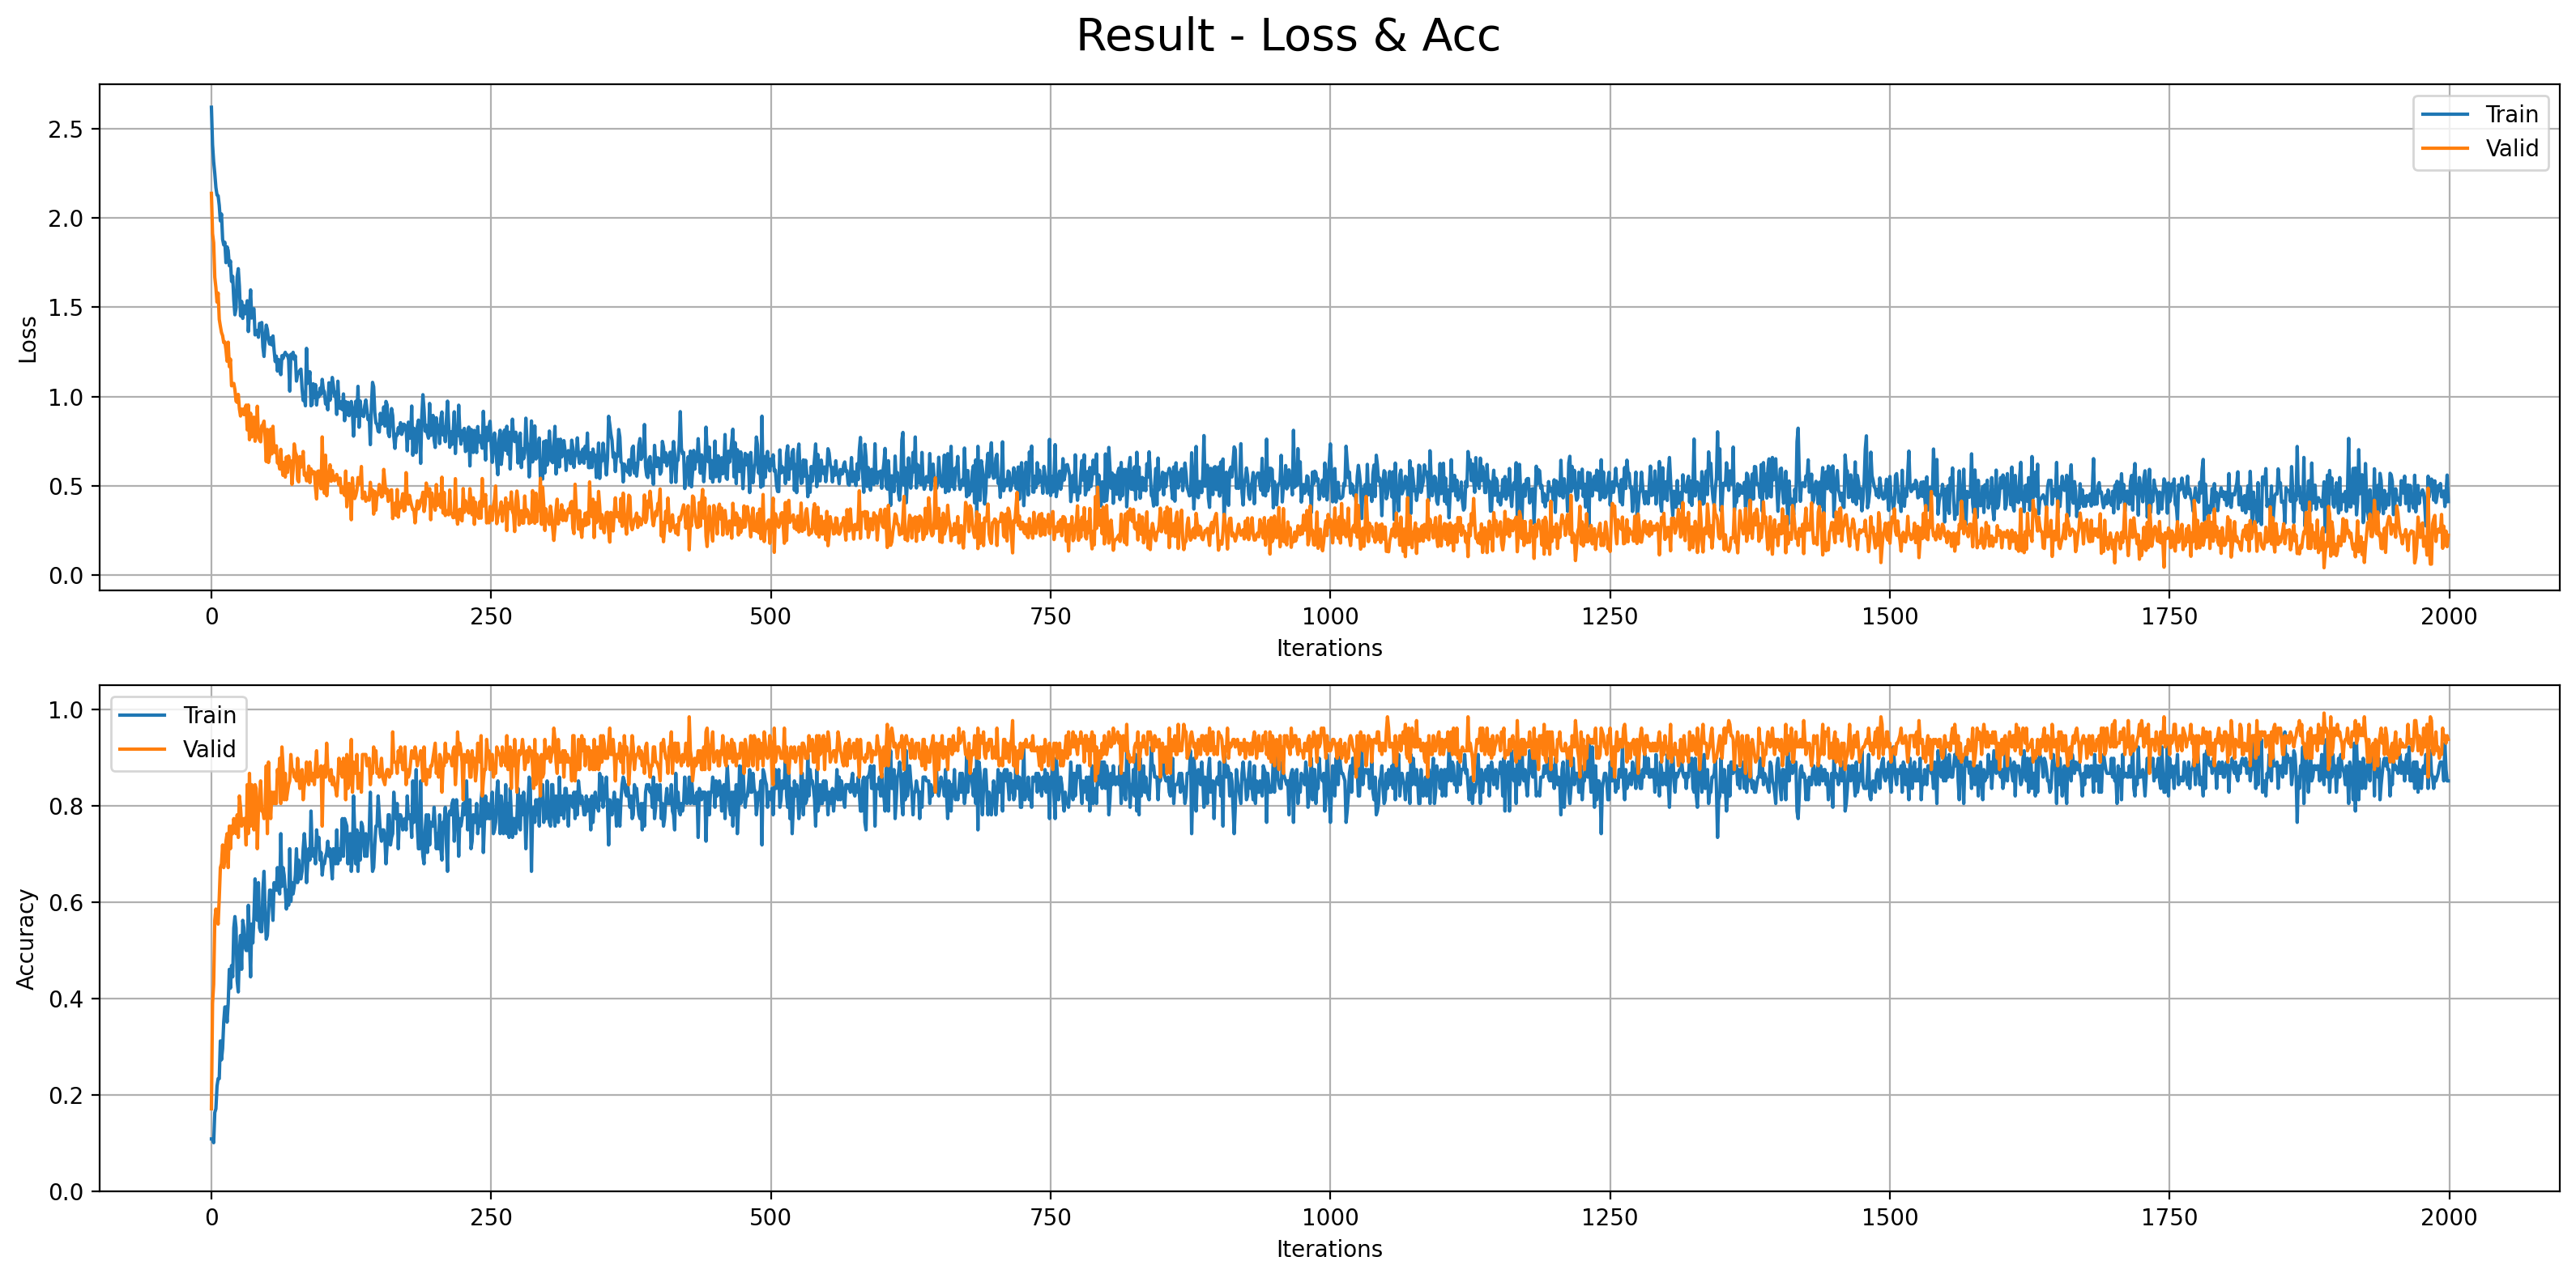

In [32]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = AdaGrad(lr=0.01)

# 모델 학습 및 검증 시작
trainer_adagrad = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_adagrad.run()

# 결과 시각화
trainer_adagrad.show_results()

In [33]:
class RMSprop:

    # 학습률(learning rate)와 감쇠율(decay rate) 설정
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr                  # 학습률 설정
        self.decay_rate = decay_rate  # 감쇠율 설정
        self.h = None                 # 이전 기울기의 제곱 합의 이동 평균을 저장할 변수 초기화

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 h를 파라미터와 동일한 형상의 0으로 초기화
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        # 각 파라미터에 대해
        for key in params.keys():

            # h를 감쇠율로 감소시키고
            self.h[key] *= self.decay_rate

            # 기울기의 제곱의 (1-감쇠율) 비율을 더한다.
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]

            # 파라미터 업데이트 (RMSprop 특징 부분)
            # 0으로 나누는 것을 방지하기 위한 작은 상수 추가
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

[Elpased Time: 0:00:00.024514] Iter:    0 Train Loss : 2.5323 Train Acc : 0.09 Valid Loss : 2.4568 Valid Acc : 0.17 
[Elpased Time: 0:00:00.441638] Iter:  100 Train Loss : 0.6153 Train Acc : 0.84 Valid Loss : 0.2441 Valid Acc : 0.91 
[Elpased Time: 0:00:00.848002] Iter:  200 Train Loss : 0.4379 Train Acc : 0.89 Valid Loss : 0.3358 Valid Acc : 0.91 
[Elpased Time: 0:00:01.300451] Iter:  300 Train Loss : 0.5037 Train Acc : 0.88 Valid Loss : 0.2693 Valid Acc : 0.92 
[Elpased Time: 0:00:01.698921] Iter:  400 Train Loss : 0.4152 Train Acc : 0.88 Valid Loss : 0.1271 Valid Acc : 0.96 
[Elpased Time: 0:00:02.156450] Iter:  500 Train Loss : 0.4292 Train Acc : 0.90 Valid Loss : 0.1102 Valid Acc : 0.95 
[Elpased Time: 0:00:02.558120] Iter:  600 Train Loss : 0.4456 Train Acc : 0.81 Valid Loss : 0.0694 Valid Acc : 0.98 
[Elpased Time: 0:00:02.956193] Iter:  700 Train Loss : 0.2987 Train Acc : 0.90 Valid Loss : 0.1690 Valid Acc : 0.95 
[Elpased Time: 0:00:03.355779] Iter:  800 Train Loss : 0.3620 Tr

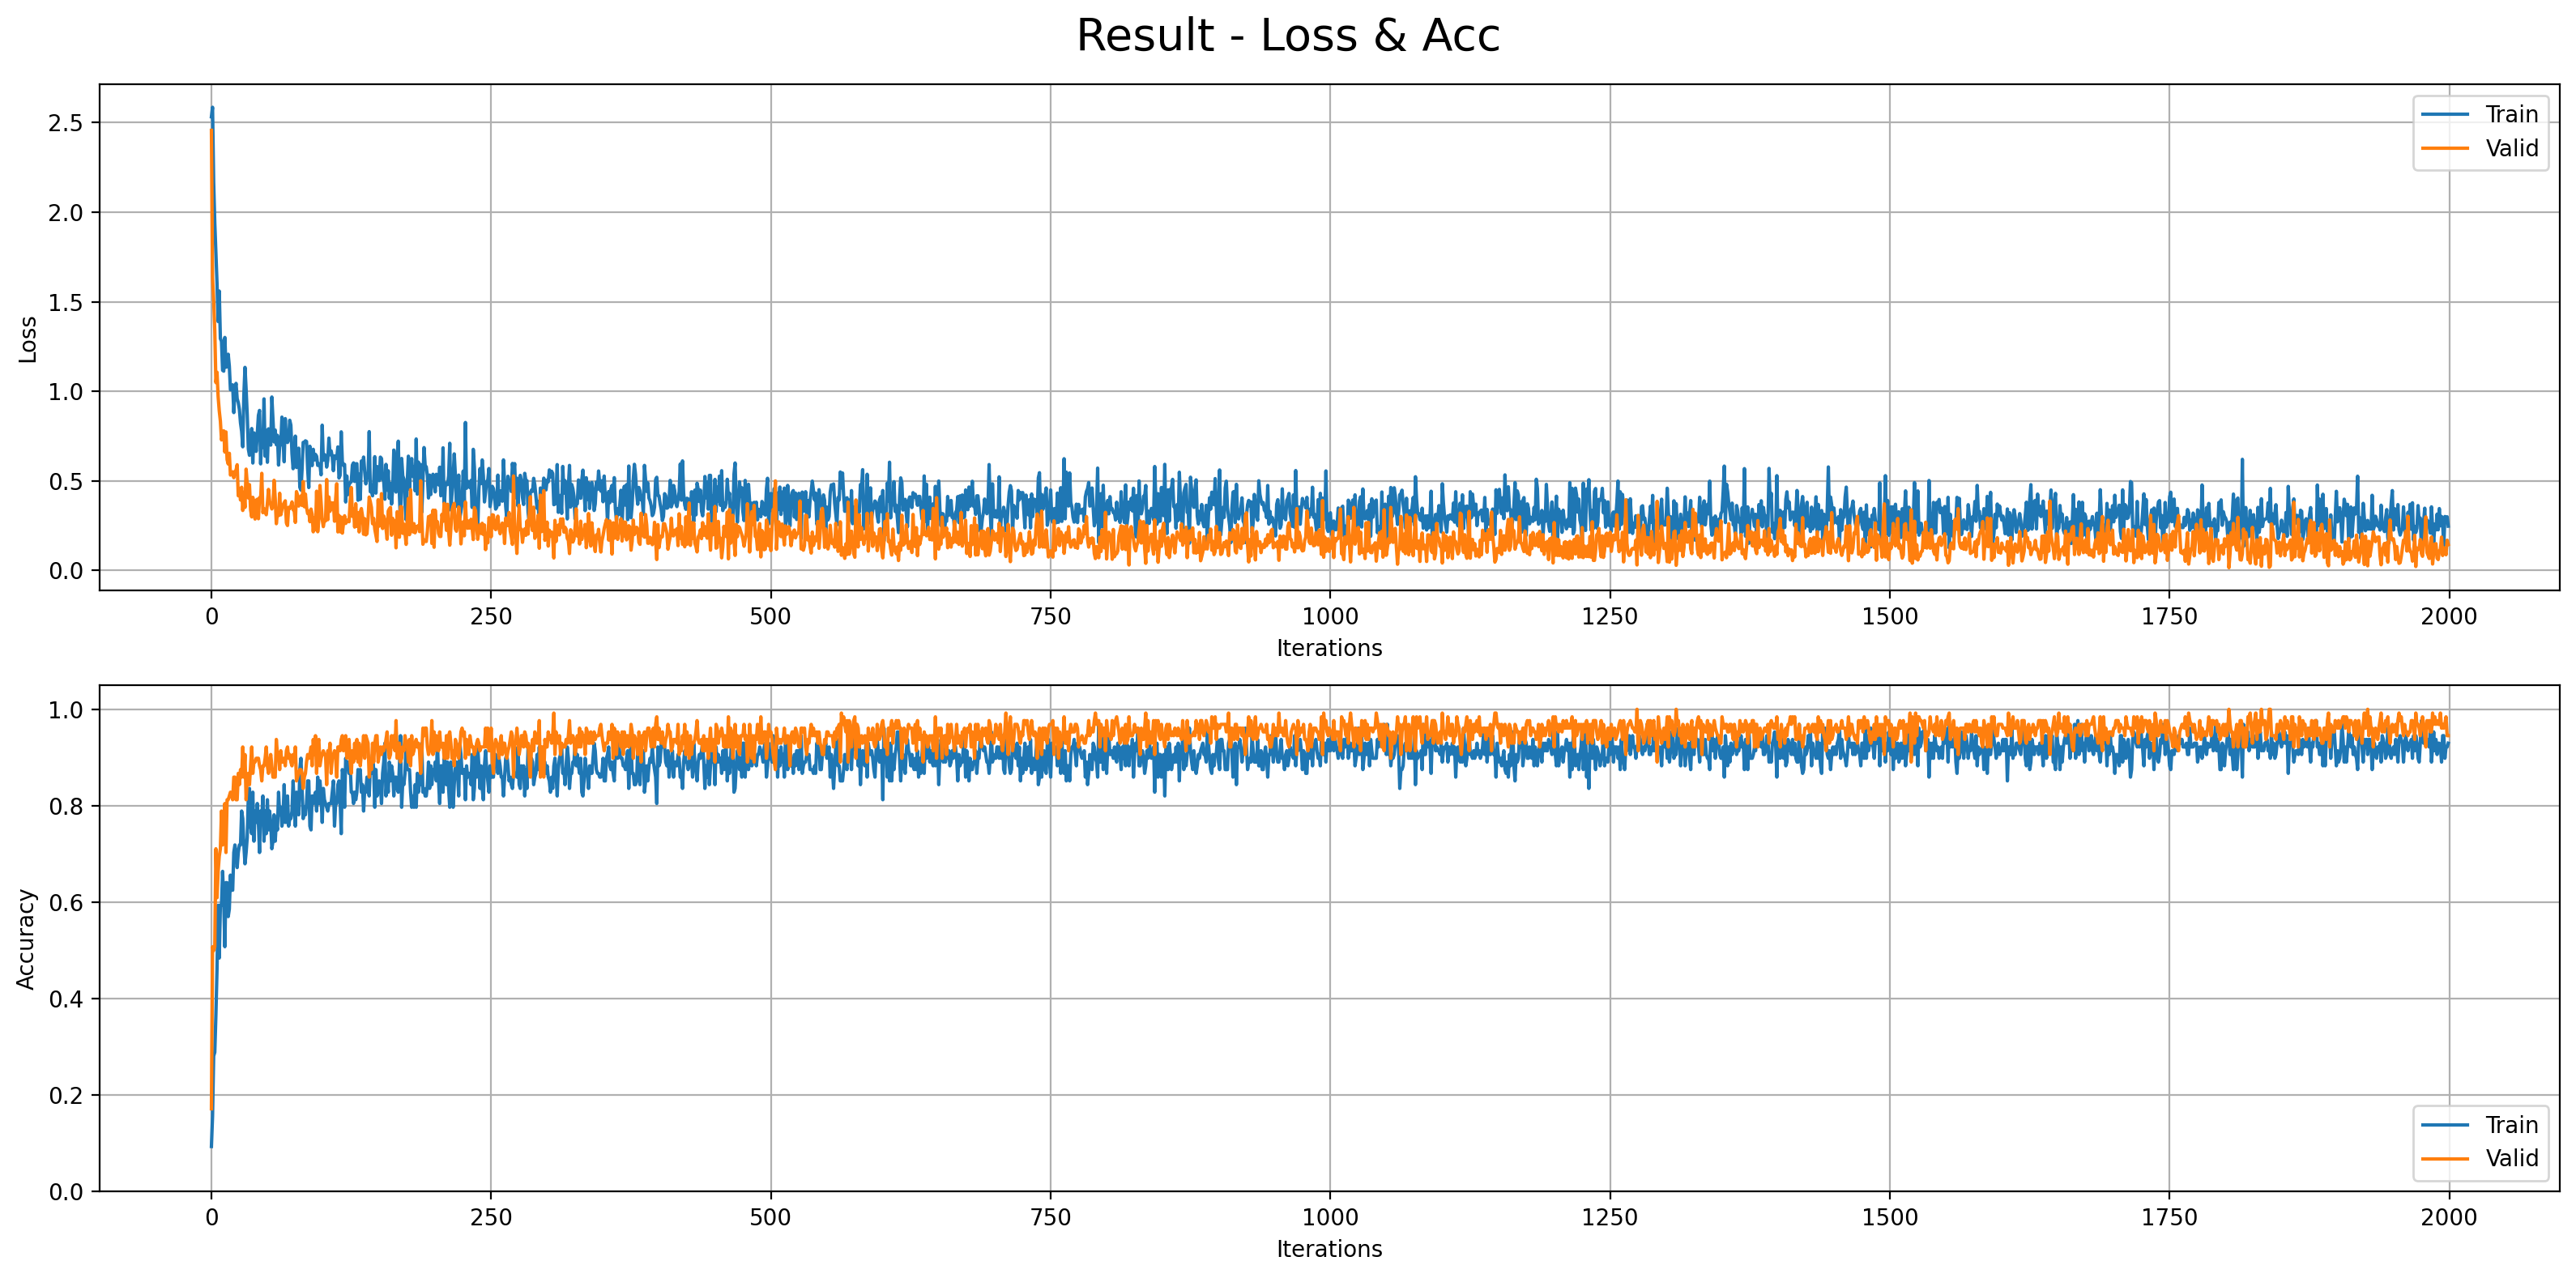

In [34]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = RMSprop(lr=0.01, decay_rate=0.99)

# 모델 학습 및 검증 시작
trainer_rmsprop = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_rmsprop.run()

# 결과 시각화
trainer_rmsprop.show_results()

In [35]:
class Adam:

    # Adam의 기본 하이퍼파라미터들을 초기화
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr       # 학습률
        self.beta1 = beta1 # 모멘텀에 사용되는 계수
        self.beta2 = beta2 # RMSprop에 사용되는 계수
        self.iter = 0      # 반복 횟수 저장용
        self.m = None      # 1차 모멘텀용 누적 값
        self.v = None      # 2차 모멘텀용 누적 값 (제곱된 기울기의 이동 평균)

    # 파라미터 업데이트 함수
    def update(self, params, grads):

        # 첫 번째 호출 시 m, v 초기화
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        # 반복 횟수 증가
        self.iter += 1

        # 학습률의 바이어스 보정 (bias correction)
        # 이는 초기 불안정한 학습을 안정적으로 도와줌
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        # 각 파라미터에 대해
        for key in params.keys():

            # 1차 모멘텀 계산
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])

            # 2차 모멘텀 (제곱된 기울기의 이동 평균) 계산
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            # 파라미터 업데이트
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

[Elpased Time: 0:00:00.028388] Iter:    0 Train Loss : 2.5146 Train Acc : 0.12 Valid Loss : 2.3800 Valid Acc : 0.11 
[Elpased Time: 0:00:00.463914] Iter:  100 Train Loss : 1.3990 Train Acc : 0.59 Valid Loss : 0.8805 Valid Acc : 0.77 
[Elpased Time: 0:00:00.881921] Iter:  200 Train Loss : 1.0029 Train Acc : 0.69 Valid Loss : 0.4730 Valid Acc : 0.90 
[Elpased Time: 0:00:01.298007] Iter:  300 Train Loss : 0.7579 Train Acc : 0.77 Valid Loss : 0.3208 Valid Acc : 0.91 
[Elpased Time: 0:00:01.755351] Iter:  400 Train Loss : 0.5902 Train Acc : 0.87 Valid Loss : 0.2110 Valid Acc : 0.95 
[Elpased Time: 0:00:02.192342] Iter:  500 Train Loss : 0.4508 Train Acc : 0.83 Valid Loss : 0.3924 Valid Acc : 0.91 
[Elpased Time: 0:00:02.622194] Iter:  600 Train Loss : 0.4566 Train Acc : 0.89 Valid Loss : 0.1733 Valid Acc : 0.94 
[Elpased Time: 0:00:03.039901] Iter:  700 Train Loss : 0.4892 Train Acc : 0.83 Valid Loss : 0.1423 Valid Acc : 0.97 
[Elpased Time: 0:00:03.455539] Iter:  800 Train Loss : 0.6632 Tr

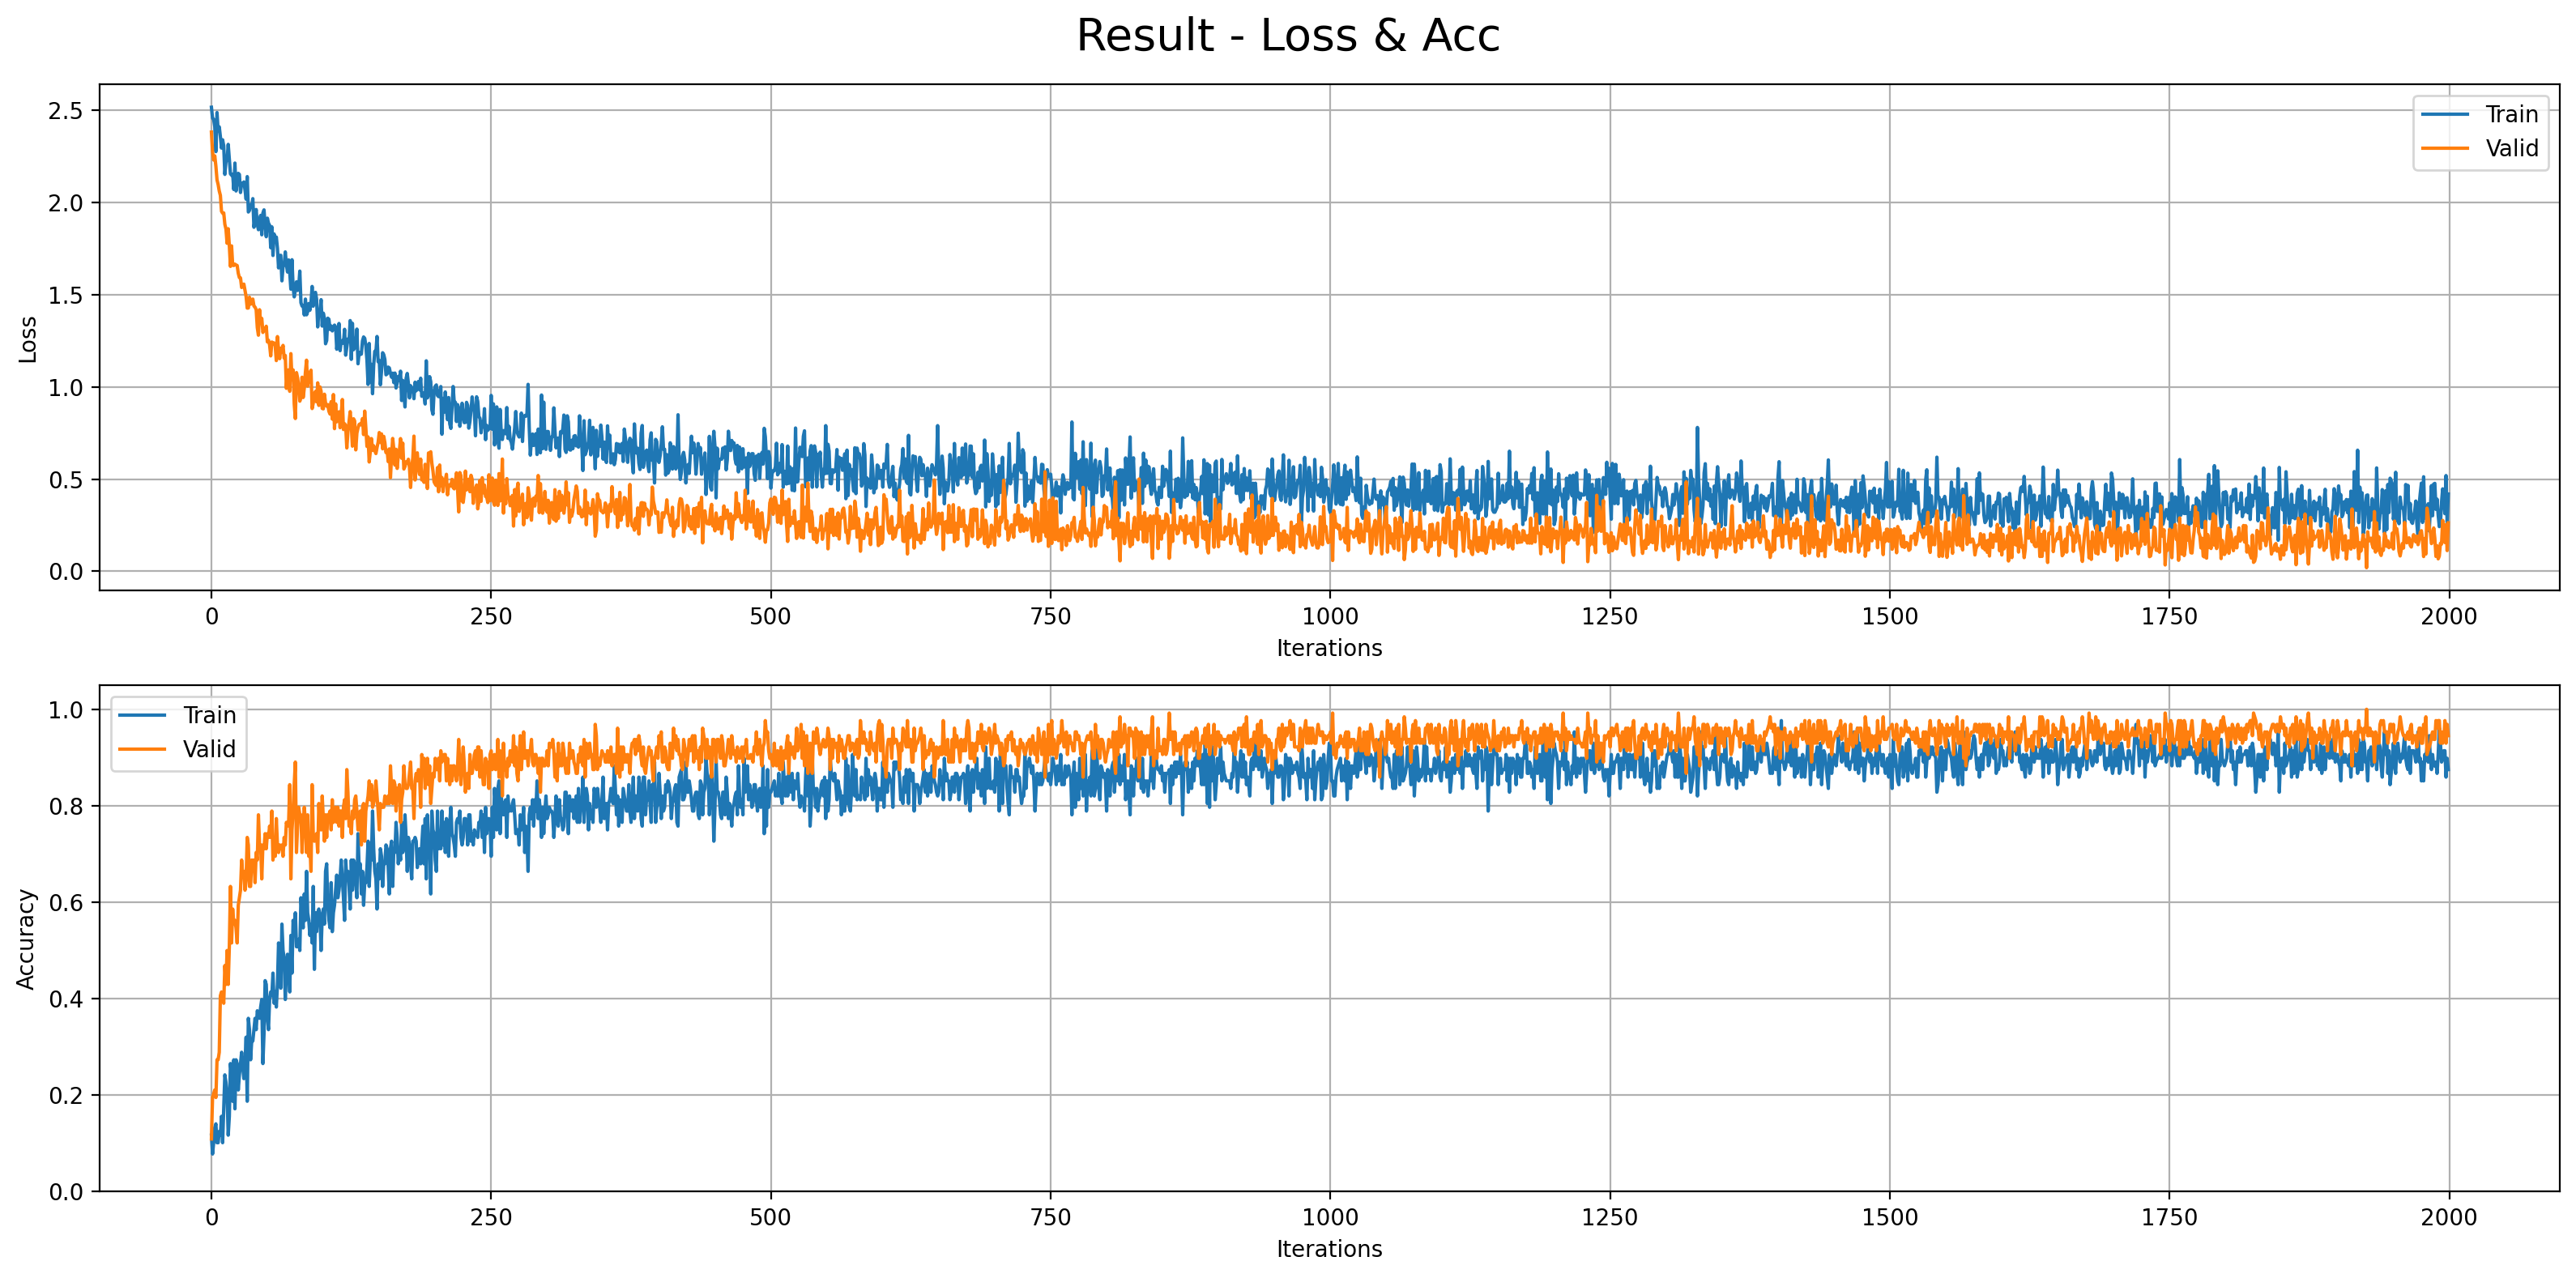

In [36]:
# 모델
model = Net(
    input_size=784,
    hidden_size_list=[100, 100, 100],
    output_size=10,
    use_batchnorm=True,
    weight_init_std='he',
    use_dropout=True,
    dropout_ratio=0.5,
)

# 옵티마이저
optimizer = Adam(lr=0.001, beta1=0.9, beta2=0.999)

# 모델 학습 및 검증 시작
trainer_adam = Trainer(
    X_train, y_train,
    X_valid, y_valid,
    model=model,
    optimizer=optimizer,
    max_iterations=2000,
    batch_size=128,
)
trainer_adam.run()

# 결과 시각화
trainer_adam.show_results()

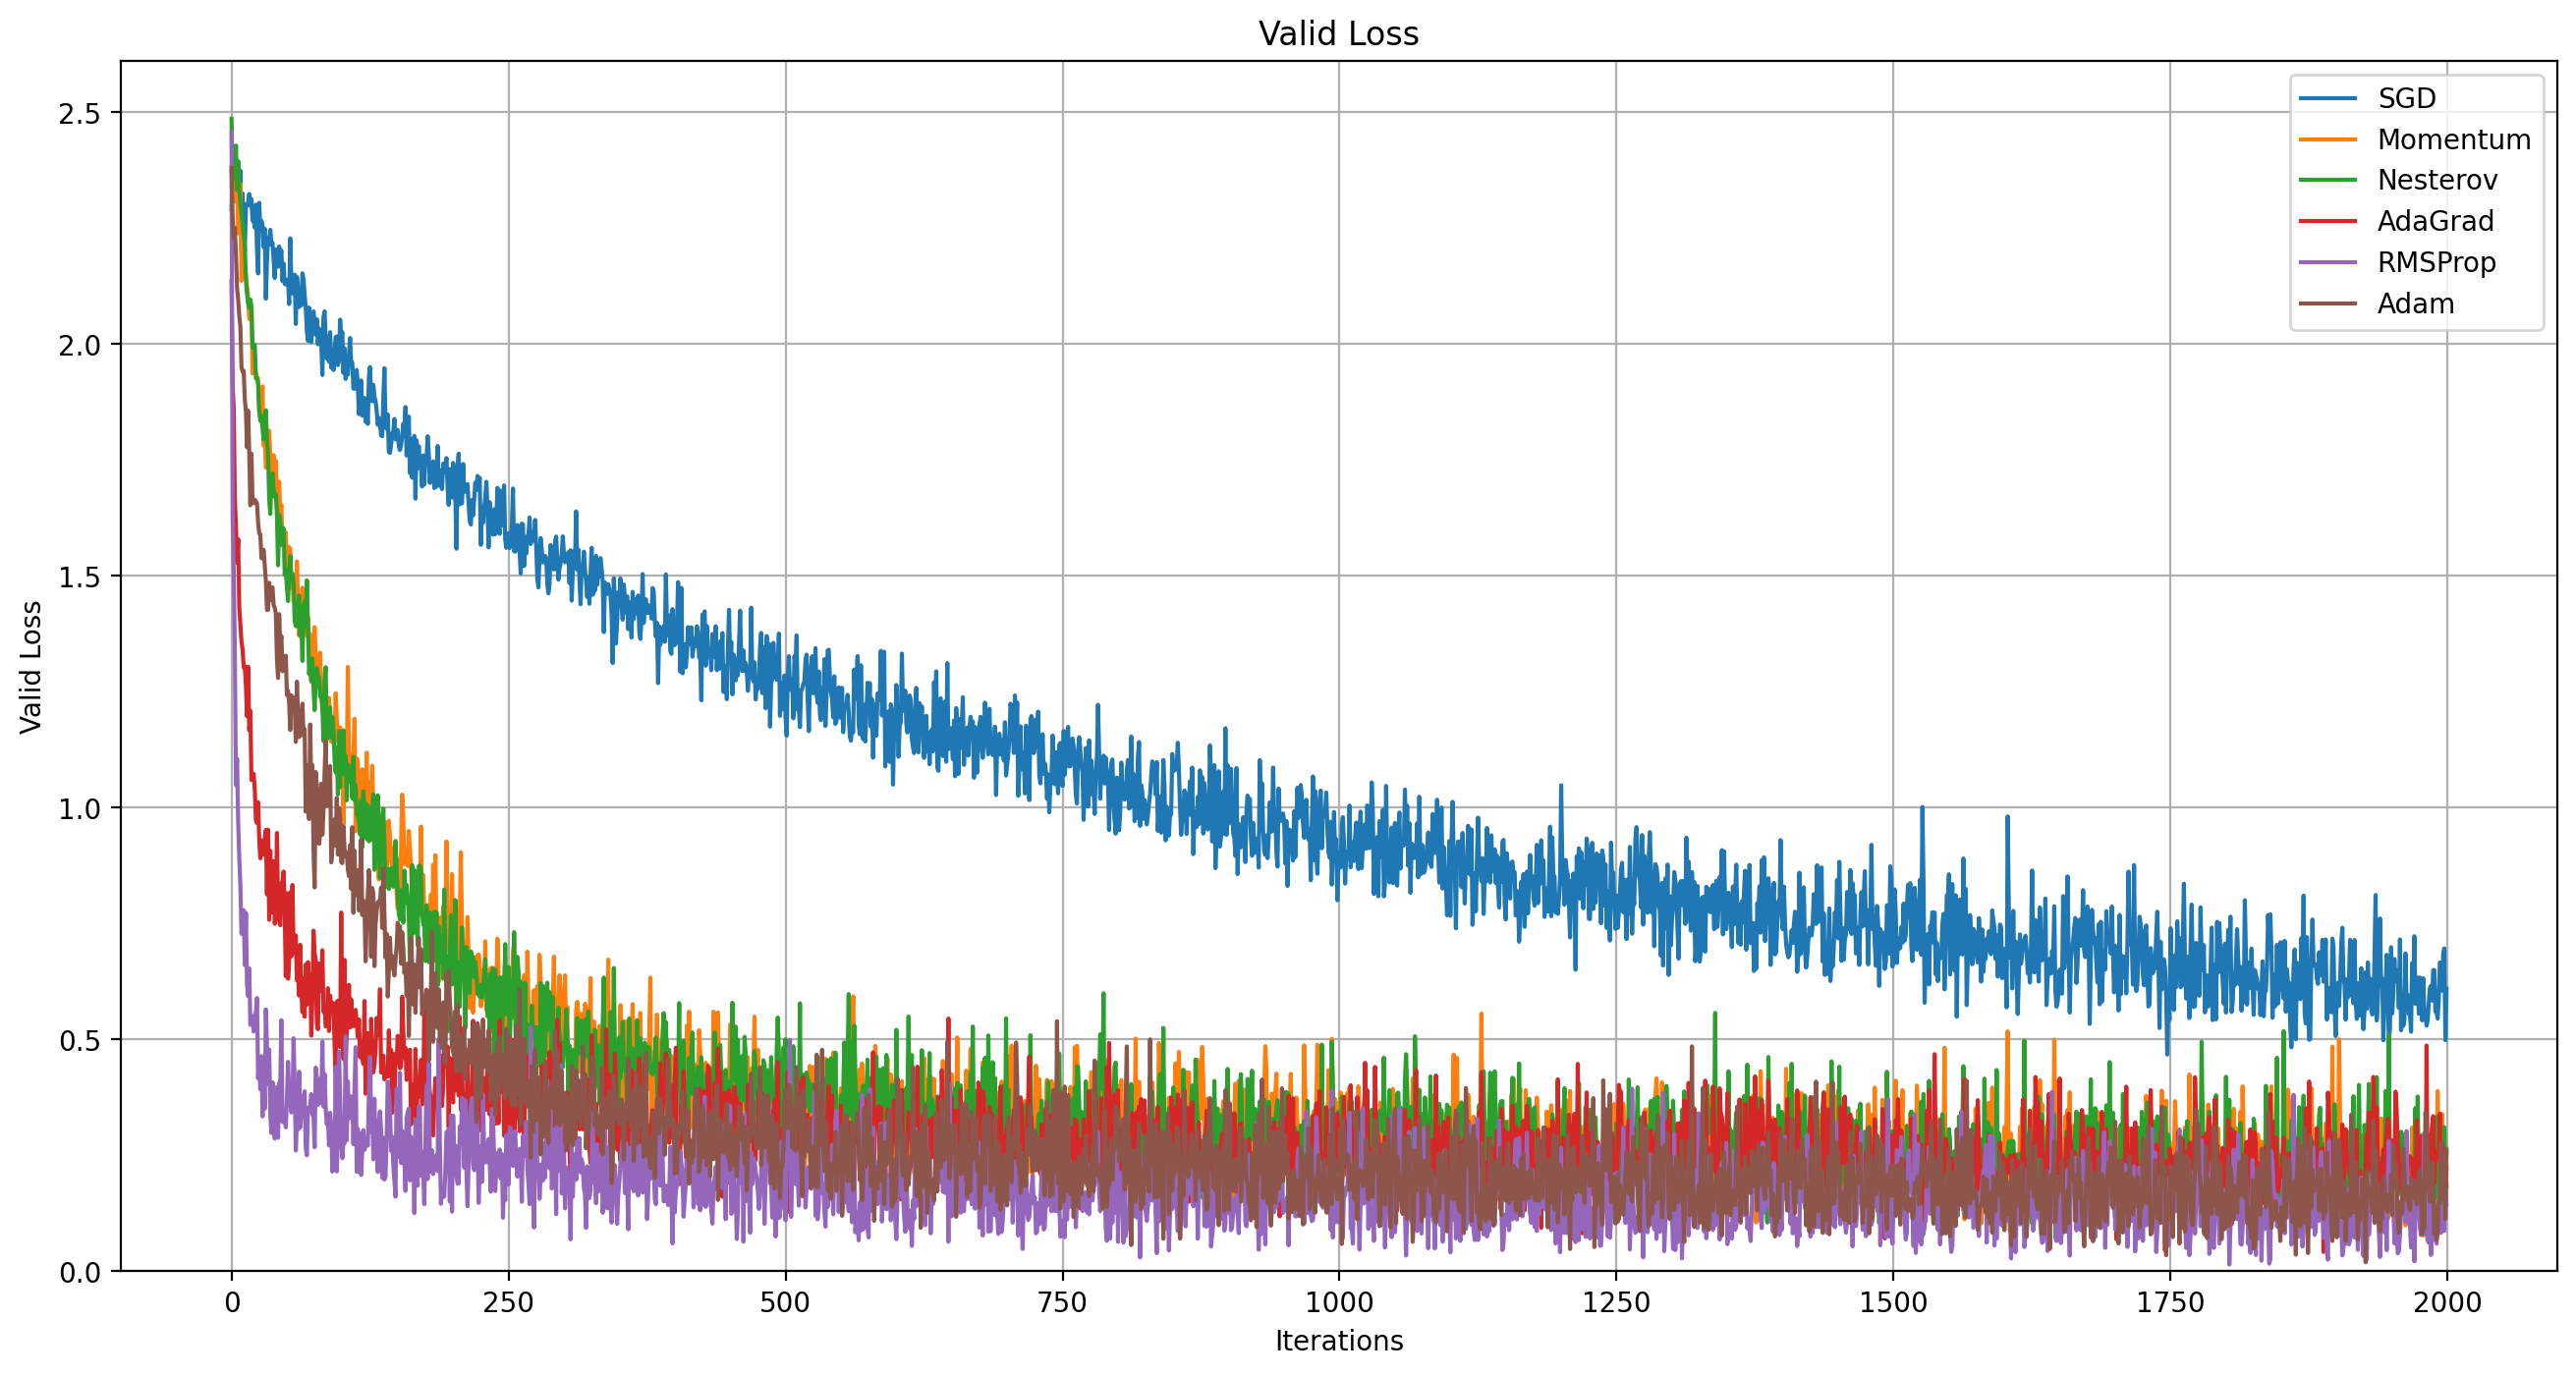

In [37]:
plt.figure(figsize=(16,8))

plt.plot(trainer_sgd.valid_loss_list)
plt.plot(trainer_momentum.valid_loss_list)
plt.plot(trainer_nesterov.valid_loss_list)
plt.plot(trainer_adagrad.valid_loss_list)
plt.plot(trainer_rmsprop.valid_loss_list)
plt.plot(trainer_adam.valid_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Loss')
plt.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])
plt.ylim(0,)

plt.title('Valid Loss')
plt.grid(True)
plt.show()

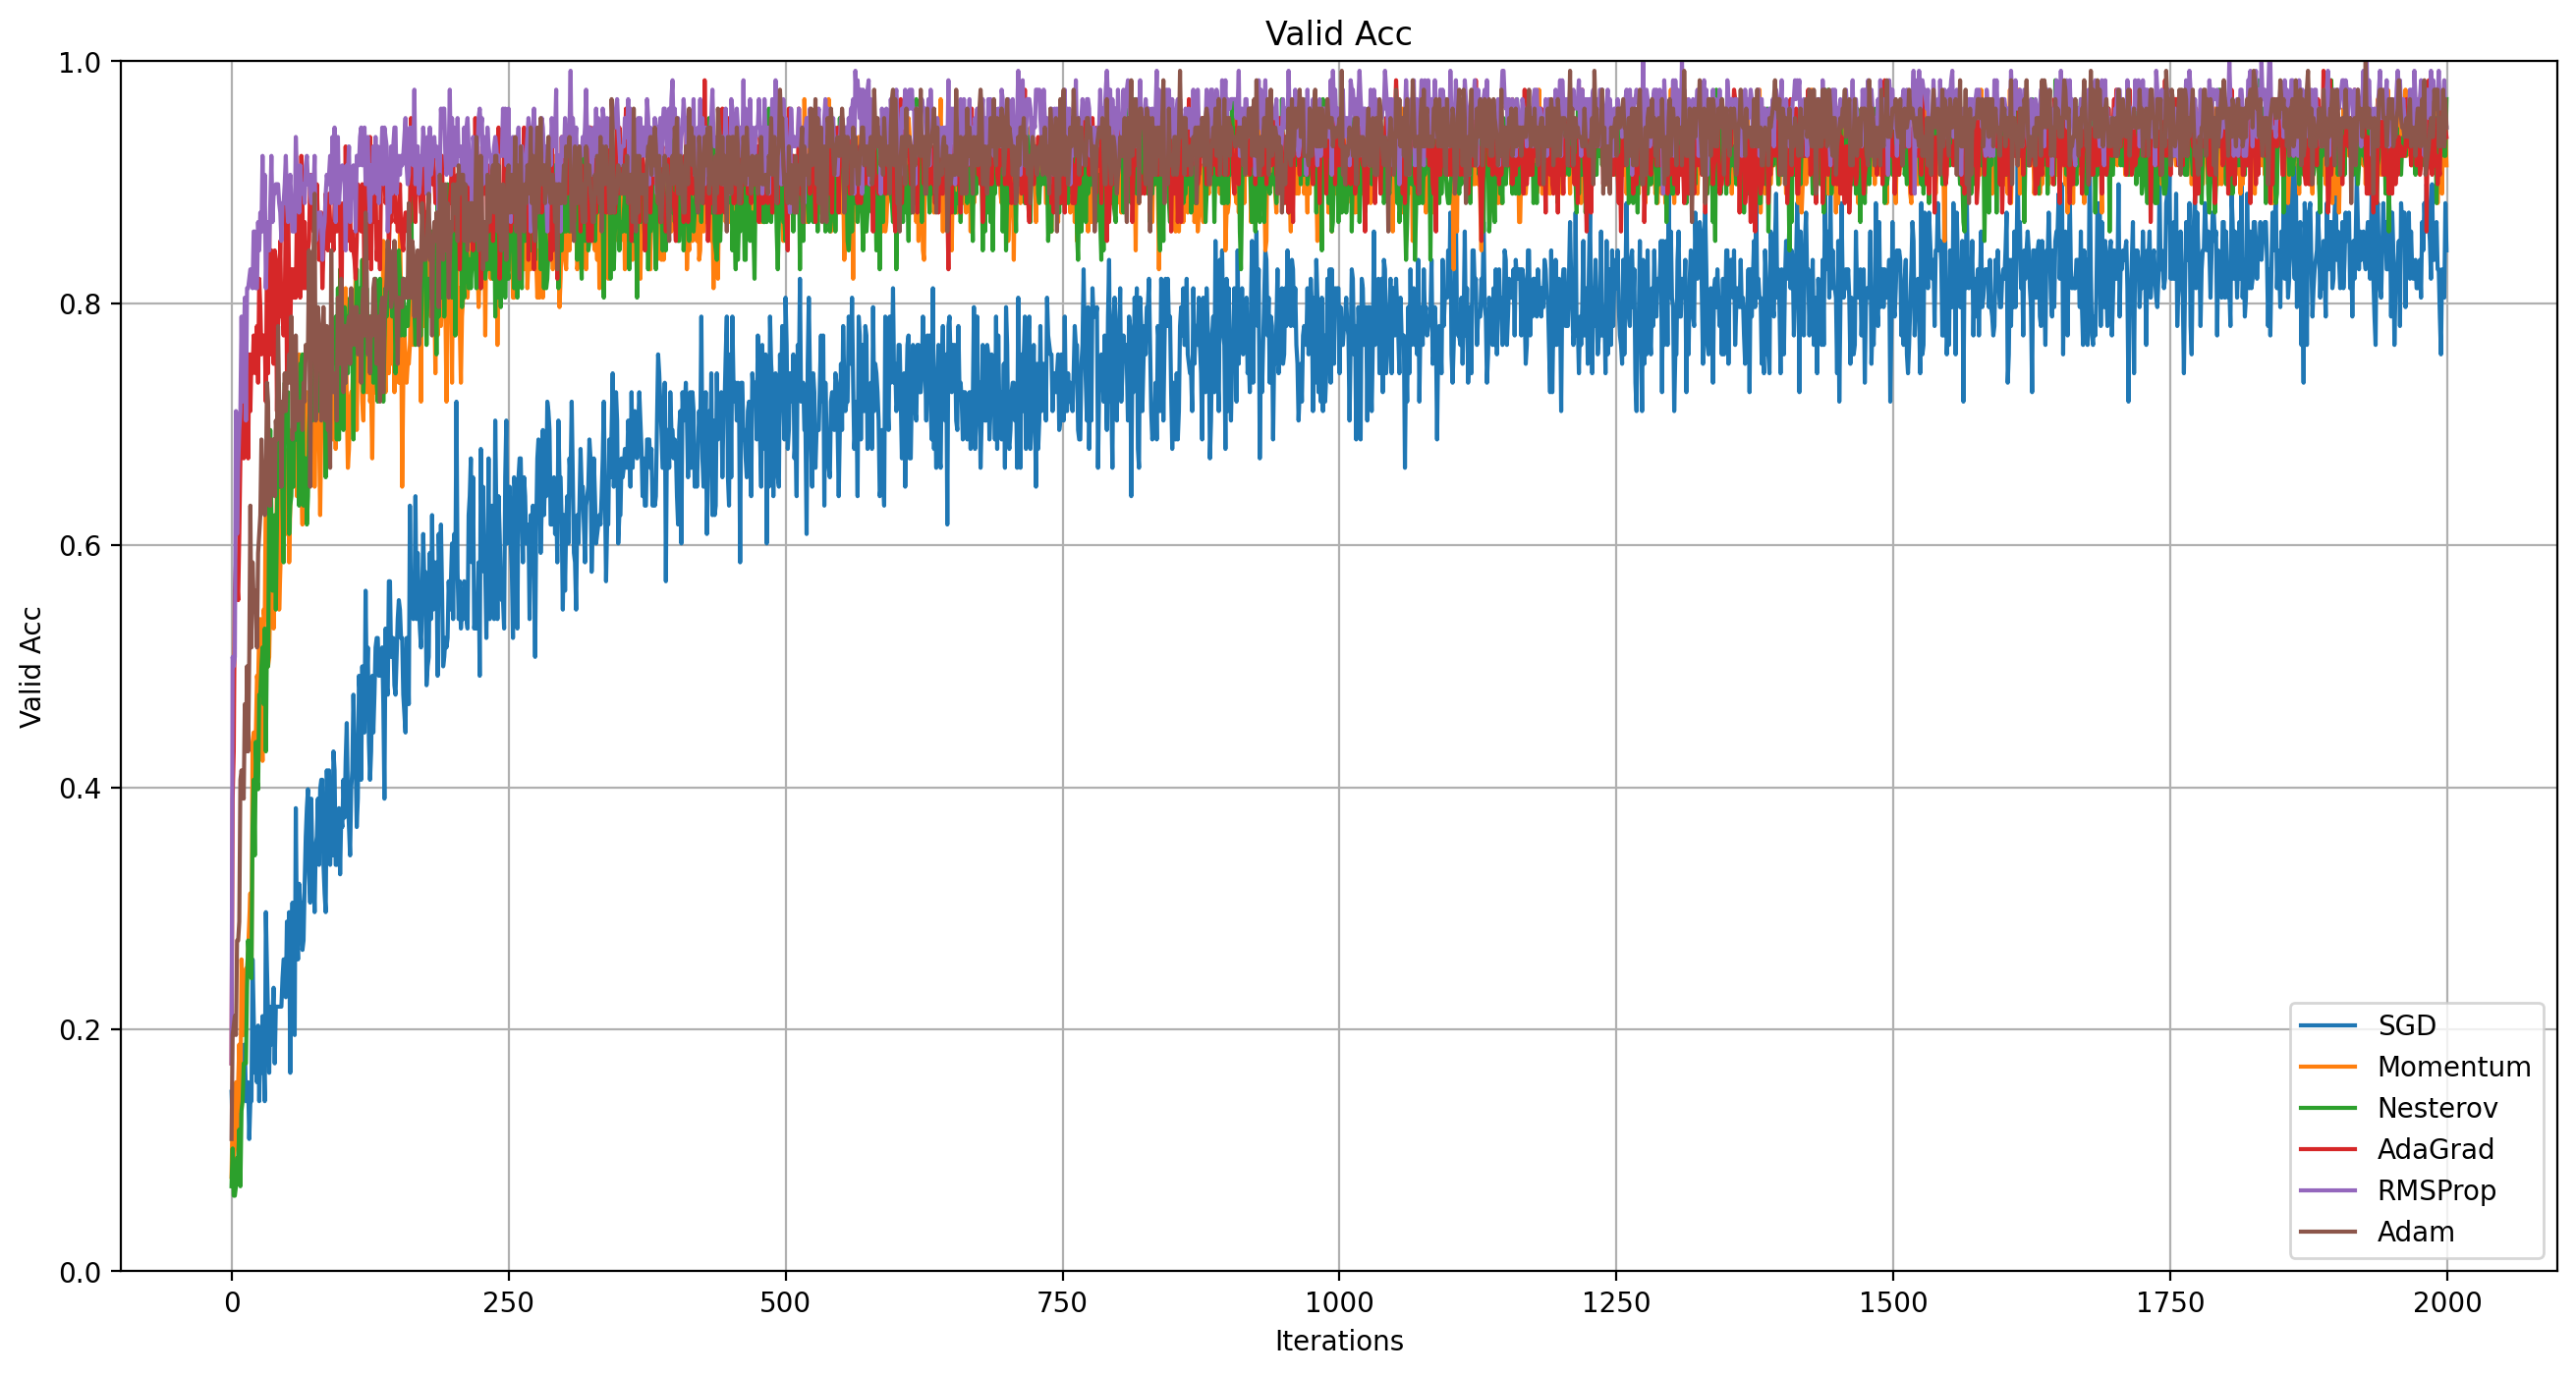

In [38]:
plt.figure(figsize=(16,8))

plt.plot(trainer_sgd.valid_acc_list)
plt.plot(trainer_momentum.valid_acc_list)
plt.plot(trainer_nesterov.valid_acc_list)
plt.plot(trainer_adagrad.valid_acc_list)
plt.plot(trainer_rmsprop.valid_acc_list)
plt.plot(trainer_adam.valid_acc_list)

plt.xlabel('Iterations')
plt.ylabel('Valid Acc')
plt.legend(['SGD', 'Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam'])
plt.ylim(0,1)

plt.title('Valid Acc')
plt.grid(True)
plt.show()